## Training the Neural Network

Importing the required packages

In [1]:
from astropy.table import Table
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
from time import time
from sklearn.preprocessing import StandardScaler
import pandas as pd
from gaiaxpy import generate, PhotometricSystem

Converting to GPU if available

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Checking directory

In [3]:
%%bash
cd /scratch/
pwd

/scratch


loading initial variables, being how the data is scaled, batchsize, learning rate, number of epochs, optimization algorithm, loss function, and dataset

In [4]:
# scalers for dataloading
metscaler = StandardScaler()
logscaler = StandardScaler()
tefscaler = StandardScaler()
amscaler = StandardScaler()
scale = 'gmag_scale'

batchlen = 32
lr = 1e-4
epochs = 10
optimize = 'Adam'
datafname = '/arc/home/aydanmckay/filtered_apogee_bprp_gmag.h5'
datashort = 'filtered_apogee_resnet_no_do'
# edited in training loop as well.
lossname = 'L2'

Defining the dataset classes. train_set and valid_set are no longer used.

In [5]:
# defining the Dataset class
class data_set(Dataset):
    '''
    Main way to access the .h5 file.
    '''
    def __init__(self,file,train=True,valid=False,test=False,noscale=False):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        if train:
            dset = self.f['group_1']['data']
            d = dset[:]
            dat = np.array([
                metscaler.fit_transform(d[[0]].T).flatten(),
                logscaler.fit_transform(d[[1]].T).flatten(),
                tefscaler.fit_transform(d[[2]].T).flatten(),
                amscaler.fit_transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif valid:
            dset = self.f['group_2']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif test:
            dset = self.f['group_3']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif noscale:
            dset = self.f['group_3']['data']
            d = dset[:]
            self.l = d.shape[1]
            self.x = torch.Tensor(d.T)
        
        # get label
        if train:
            ydset = self.f['group_1']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat[:].T) # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        elif valid:
            ydset = self.f['group_2']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat[:].T)
        elif test:
            ydset = self.f['group_3']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat[:].T)
        elif noscale:
            ydset = self.f['group_3']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat.T)
        
        # get error in label # comment out for non-error label runs
        if train:
            errdset = self.f['group_1']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif valid:
            errdset = self.f['group_2']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif test or noscale:
            errdset = self.f['group_3']['e_label']
            self.err = torch.Tensor(errdset[:].T)
            
        if train:
            gdset = self.f['group_1']['gmag']
            self.g = torch.Tensor(gdset[:].T)
        elif valid:
            gdset = self.f['group_2']['gmag']
            self.g = torch.Tensor(gdset[:].T)
        elif test or noscale:
            gdset = self.f['group_3']['gmag']
            self.g = torch.Tensor(gdset[:].T)
        
    def __len__(self):
        return self.l
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        gg = self.g[index]
        errg = self.err[index]
        return (xg,yg,gg,errg)

Defining networks

In [6]:
class ResBlock(nn.Module):
    '''
    check this guy out, might not be using sigmoid when I should be.
    '''
    def __init__(self, nodes):
        super(ResBlock, self).__init__()
        self.res_block1 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
            nn.LeakyReLU(),
            # nn.Sigmoid(),
        )
        self.res_block2 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
        )
        self.lrelu = nn.LeakyReLU()
        self.siggy = nn.Sigmoid()
#         add dropout in the init
        self.do = nn.Dropout() #
    
    def forward(self, x):
        res = x
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x + res
        output = self.lrelu(x)
        # output = self.siggy(x)
#         add dropout after the relu
        # output = self.do(x) #
        return output
        
class ResNetM(nn.Module):
    def __init__(self):
        super(ResNetM, self).__init__()
        self.input_block = nn.Sequential(
            nn.Linear(4,16),
            nn.LeakyReLU(),
        )
        self.blocklist = nn.ModuleList([
            ResBlock(16),
            ResBlock(16),
            nn.Linear(16,32),
            ResBlock(32),
            ResBlock(32),
            nn.Linear(32,64),
            ResBlock(64),
            ResBlock(64),
            nn.Linear(64,128),
            ResBlock(128),
            ResBlock(128),
        ])
        self.output_block = nn.Sequential(
            nn.Linear(128,110),
        )
        
    def forward(self,x):
        x = self.input_block(x)
        for i, _ in enumerate(self.blocklist):
            x = self.blocklist[i](x)
        logits = self.output_block(x)
        return logits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 110),
            # nn.Linear(128,110),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# try 3-layer simple network with sigmoid

Accessing datasets

In [7]:
training_data = data_set(datafname)
valid_data = data_set(datafname,train=False,valid=True)

Creating dataloaders

In [8]:
train_dataloader = DataLoader(
    training_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)
# add gaussian noise to data

Selecting a model

In [9]:
model = ResNetM()
# model = Net()
model = model.to(device)

Choosing the loss function

In [15]:
if lossname == 'L1':
    loss_fn = nn.L1Loss()
elif lossname == 'L2':
    loss_fn = nn.MSELoss()
elif lossname == 'Gauss':
    loss_fn = nn.GaussianNLLLoss()
# MAELoss

selecing the optimizaition algorithm

In [16]:
if optimize == 'SGD':
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        # weight_decay=1e-1
    )
    # weight decay -> 1e-1, 1e-3, 1e-5
elif optimize == 'Adam':
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     'min'
# )

plotting functions not often used and potentially broken

In [12]:
def res(preds,dataloader,epoch,resi='rel'):
    fig, axs = plt.subplots(110)
    fig.set_figheight(600)
    
    with torch.no_grad():
        for num, (X, y, z) in enumerate(dataloader):
            if resi == 'rel':
                residual = (y-preds[num])/y
                string = 'Relative Residual'
            elif resi == 'err':
                residual = (y-preds[num])/z
                string = 'Residual Over Label Error'
            elif resi == 'res':
                residual = y-preds[num]
                string = 'Residual'
            for it in range(len(y.T)):
                axs[it].plot(y.T[it],residual.T[it],'k.',alpha=0.1)
                axs[it].set_xlabel('Observed XP Coefficient Value')
                axs[it].set_ylabel('Relative Residual')
                axs[it].set_title('XP Coefficient '+str(it+1)+' '+string)
                
    plt.savefig('/arc/home/aydanmckay/torchplots/test'+resi+'residualsWL1epoch'+str(epoch)+'scalecutsep5.png')
    plt.close()
    
def diagplot(preds,dataloader,epoch):
    # fig, axs = plt.subplots(110)
    # fig.set_figheight(600)
    data = []
    labels = []
    with torch.no_grad():
        for num, (X, y, z) in enumerate(dataloader):
            for datum,true in zip(X,y):
                data.append(datum)
                labels.append(true)
        plt.scatter([datum[0] for datum in data],[(pred[0]-y[0])/y[0] for pred,y in zip(preds,labels)],label='Bp Coefficient 1')
        plt.scatter([datum[0] for datum in data],[(pred[54]-y[54])/y[54] for pred,y in zip(preds,labels)],label='Rp Coefficient 1')
        plt.legend()
        plt.title('BP and RP Coefficient 1')
        plt.xlabel('Teff')
        plt.ylabel('Relative Residual')
        # plt.savefig('/arc/home/aydanmckay/torchresplots/test'+str(epoch)+'minmaxnoscalebig32diagplot.png')
        # plt.close()
        plt.show()

Train and Validation functions

In [13]:
normalize = lambda x, n: x / (10 ** (8.5 - n / 2.5))

def train(dataloader, model, loss_fn, optimizer, scheduler, device):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    losses = []
    for batch, (X, y, g, z) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        g = g.to(device)
        # z = z.to(device)
        
        Y = normalize(y.T, g).T
        
        pred = model(X)
        loss = loss_fn(pred,Y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())

        if (batch % 250 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {running_loss/(batch+1):>7f}  [{current:>5d}/{size:>5d}]")
        
    scheduler.step()
            
    print(f"loss: {running_loss/len(dataloader):>7f}  [{size:>5d}/{size:>5d}]")
    plt.plot(np.arange(0,len(losses)),losses)
    plt.xlabel('Batch')
    plt.ylabel('Loss ('+lossname+')')
    plt.show()
    return running_loss/len(dataloader)

def valid(dataloader, model, loss_fn, epoch, device, plots = False):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    preds = []
    with torch.no_grad():
        for X, y, g, z in dataloader:
            X = X.to(device)
            y = y.to(device)
            g = g.to(device)
            # z = z.to(device)
            
            Y = normalize(y.T, g).T
            
            pred = model(X)
            valid_loss += loss_fn(pred, Y).item()
            correct += (pred == Y).type(torch.float).sum().item()
            if plots == True:
                for prediction in pred:
                    preds.append(prediction.to('cpu'))
    
    if plots == True:
        preds = np.array(preds)
        # res(preds,dataloader,epoch,resi='res')
        # res(preds,dataloader,epoch,resi='rel')
        # res(preds,dataloader,epoch,resi='err')
        diagplot(preds,dataloader,epoch)
    
    valid_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>8f}%, Avg loss: {valid_loss:>8f} \n")
    return valid_loss

Train and validation loop for the NN

Epoch 1
-------------------------------
loss: 0.838949  [    0/277344]
loss: 0.250645  [ 8000/277344]
loss: 0.141019  [16000/277344]
loss: 0.100337  [24000/277344]
loss: 0.079031  [32000/277344]
loss: 0.065952  [40000/277344]
loss: 0.056932  [48000/277344]
loss: 0.050292  [56000/277344]
loss: 0.045289  [64000/277344]
loss: 0.041353  [72000/277344]
loss: 0.038110  [80000/277344]
loss: 0.035492  [88000/277344]
loss: 0.033260  [96000/277344]
loss: 0.031332  [104000/277344]
loss: 0.029702  [112000/277344]
loss: 0.028263  [120000/277344]
loss: 0.027000  [128000/277344]
loss: 0.025885  [136000/277344]
loss: 0.024866  [144000/277344]
loss: 0.023947  [152000/277344]
loss: 0.023119  [160000/277344]
loss: 0.022365  [168000/277344]
loss: 0.021674  [176000/277344]
loss: 0.021037  [184000/277344]
loss: 0.020451  [192000/277344]
loss: 0.019903  [200000/277344]
loss: 0.019387  [208000/277344]
loss: 0.018902  [216000/277344]
loss: 0.018474  [224000/277344]
loss: 0.018054  [232000/277344]
loss: 0.01766

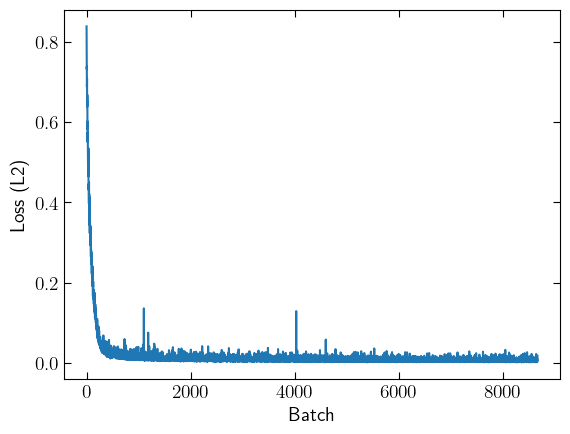

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.005115 

Elapsed epoch time: 144.00 s
Epoch 2
-------------------------------
loss: 0.004166  [    0/277344]
loss: 0.005912  [ 8000/277344]
loss: 0.006169  [16000/277344]
loss: 0.006398  [24000/277344]
loss: 0.006310  [32000/277344]
loss: 0.006213  [40000/277344]
loss: 0.006183  [48000/277344]
loss: 0.006154  [56000/277344]
loss: 0.006066  [64000/277344]
loss: 0.006008  [72000/277344]
loss: 0.006022  [80000/277344]
loss: 0.005983  [88000/277344]
loss: 0.005961  [96000/277344]
loss: 0.005921  [104000/277344]
loss: 0.005886  [112000/277344]
loss: 0.005877  [120000/277344]
loss: 0.005862  [128000/277344]
loss: 0.005844  [136000/277344]
loss: 0.005823  [144000/277344]
loss: 0.005808  [152000/277344]
loss: 0.005802  [160000/277344]
loss: 0.005799  [168000/277344]
loss: 0.005802  [176000/277344]
loss: 0.005787  [184000/277344]
loss: 0.005753  [192000/277344]
loss: 0.005744  [200000/277344]
loss: 0.005729  [208000/277344]
loss: 0.005732  [216000/

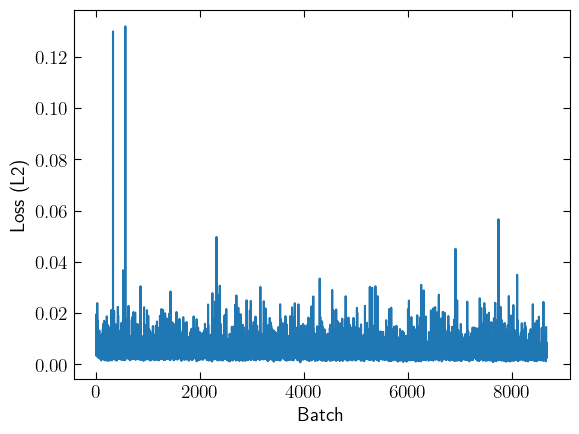

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004744 

Elapsed epoch time: 145.78 s
Epoch 3
-------------------------------
loss: 0.007076  [    0/277344]
loss: 0.005261  [ 8000/277344]
loss: 0.005192  [16000/277344]
loss: 0.005141  [24000/277344]
loss: 0.005120  [32000/277344]
loss: 0.005213  [40000/277344]
loss: 0.005200  [48000/277344]
loss: 0.005211  [56000/277344]
loss: 0.005234  [64000/277344]
loss: 0.005187  [72000/277344]
loss: 0.005226  [80000/277344]
loss: 0.005204  [88000/277344]
loss: 0.005207  [96000/277344]
loss: 0.005206  [104000/277344]
loss: 0.005215  [112000/277344]
loss: 0.005181  [120000/277344]
loss: 0.005189  [128000/277344]
loss: 0.005178  [136000/277344]
loss: 0.005182  [144000/277344]
loss: 0.005183  [152000/277344]
loss: 0.005170  [160000/277344]
loss: 0.005199  [168000/277344]
loss: 0.005181  [176000/277344]
loss: 0.005171  [184000/277344]
loss: 0.005158  [192000/277344]
loss: 0.005158  [200000/277344]
loss: 0.005163  [208000/277344]
loss: 0.005137  [216000/

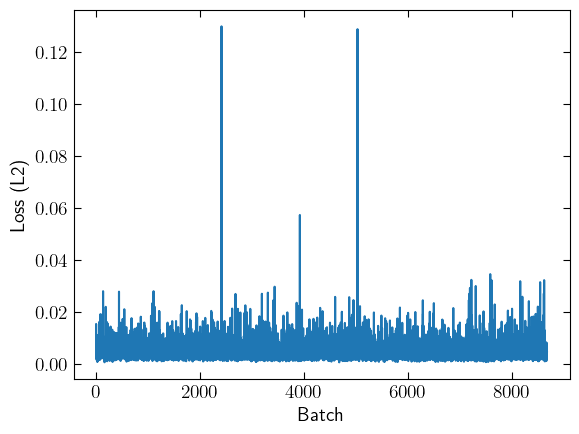

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004833 

Elapsed epoch time: 143.76 s
Epoch 4
-------------------------------
loss: 0.002668  [    0/277344]
loss: 0.005278  [ 8000/277344]
loss: 0.004808  [16000/277344]
loss: 0.004890  [24000/277344]
loss: 0.004923  [32000/277344]
loss: 0.004985  [40000/277344]
loss: 0.004982  [48000/277344]
loss: 0.004938  [56000/277344]
loss: 0.004943  [64000/277344]
loss: 0.004941  [72000/277344]
loss: 0.004941  [80000/277344]
loss: 0.005002  [88000/277344]
loss: 0.004996  [96000/277344]
loss: 0.005002  [104000/277344]
loss: 0.004985  [112000/277344]
loss: 0.004998  [120000/277344]
loss: 0.005014  [128000/277344]
loss: 0.005016  [136000/277344]
loss: 0.005026  [144000/277344]
loss: 0.005037  [152000/277344]
loss: 0.005015  [160000/277344]
loss: 0.005019  [168000/277344]
loss: 0.005021  [176000/277344]
loss: 0.005007  [184000/277344]
loss: 0.004998  [192000/277344]
loss: 0.005002  [200000/277344]
loss: 0.004997  [208000/277344]
loss: 0.004983  [216000/

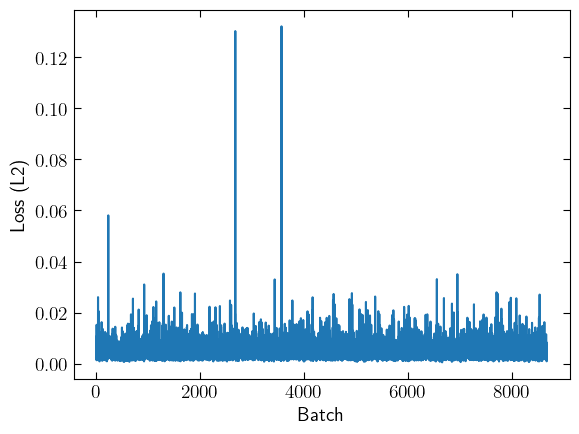

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004641 

Elapsed epoch time: 135.49 s
Epoch 5
-------------------------------
loss: 0.007465  [    0/277344]
loss: 0.005580  [ 8000/277344]
loss: 0.005101  [16000/277344]
loss: 0.005046  [24000/277344]
loss: 0.004920  [32000/277344]
loss: 0.004842  [40000/277344]
loss: 0.004896  [48000/277344]
loss: 0.004938  [56000/277344]
loss: 0.004906  [64000/277344]
loss: 0.004894  [72000/277344]
loss: 0.004877  [80000/277344]
loss: 0.004870  [88000/277344]
loss: 0.004855  [96000/277344]
loss: 0.004841  [104000/277344]
loss: 0.004848  [112000/277344]
loss: 0.004835  [120000/277344]
loss: 0.004823  [128000/277344]
loss: 0.004832  [136000/277344]
loss: 0.004847  [144000/277344]
loss: 0.004835  [152000/277344]
loss: 0.004844  [160000/277344]
loss: 0.004856  [168000/277344]
loss: 0.004861  [176000/277344]
loss: 0.004870  [184000/277344]
loss: 0.004858  [192000/277344]
loss: 0.004882  [200000/277344]
loss: 0.004886  [208000/277344]
loss: 0.004894  [216000/

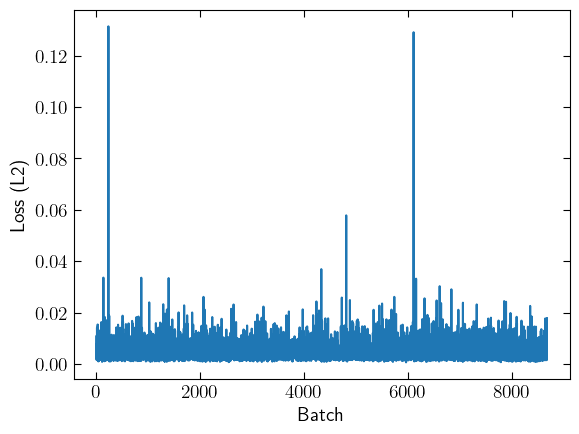

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004596 

Elapsed epoch time: 142.04 s
Epoch 6
-------------------------------
loss: 0.006614  [    0/277344]
loss: 0.004341  [ 8000/277344]
loss: 0.004439  [16000/277344]
loss: 0.004401  [24000/277344]
loss: 0.004501  [32000/277344]
loss: 0.004506  [40000/277344]
loss: 0.004489  [48000/277344]
loss: 0.004575  [56000/277344]
loss: 0.004563  [64000/277344]
loss: 0.004664  [72000/277344]
loss: 0.004633  [80000/277344]
loss: 0.004644  [88000/277344]
loss: 0.004675  [96000/277344]
loss: 0.004677  [104000/277344]
loss: 0.004687  [112000/277344]
loss: 0.004679  [120000/277344]
loss: 0.004681  [128000/277344]
loss: 0.004661  [136000/277344]
loss: 0.004641  [144000/277344]
loss: 0.004633  [152000/277344]
loss: 0.004642  [160000/277344]
loss: 0.004644  [168000/277344]
loss: 0.004638  [176000/277344]
loss: 0.004643  [184000/277344]
loss: 0.004636  [192000/277344]
loss: 0.004632  [200000/277344]
loss: 0.004634  [208000/277344]
loss: 0.004638  [216000/

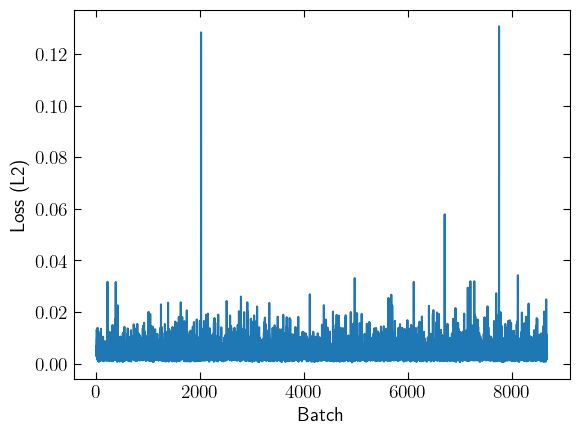

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004515 

Elapsed epoch time: 137.60 s
Epoch 7
-------------------------------
loss: 0.004453  [    0/277344]
loss: 0.005372  [ 8000/277344]
loss: 0.005025  [16000/277344]
loss: 0.004978  [24000/277344]
loss: 0.004931  [32000/277344]
loss: 0.004950  [40000/277344]
loss: 0.004829  [48000/277344]
loss: 0.004791  [56000/277344]
loss: 0.004764  [64000/277344]
loss: 0.004743  [72000/277344]
loss: 0.004700  [80000/277344]
loss: 0.004691  [88000/277344]
loss: 0.004693  [96000/277344]
loss: 0.004671  [104000/277344]
loss: 0.004666  [112000/277344]
loss: 0.004652  [120000/277344]
loss: 0.004640  [128000/277344]
loss: 0.004641  [136000/277344]
loss: 0.004661  [144000/277344]
loss: 0.004654  [152000/277344]
loss: 0.004668  [160000/277344]
loss: 0.004655  [168000/277344]
loss: 0.004661  [176000/277344]
loss: 0.004669  [184000/277344]
loss: 0.004660  [192000/277344]
loss: 0.004664  [200000/277344]
loss: 0.004663  [208000/277344]
loss: 0.004654  [216000/

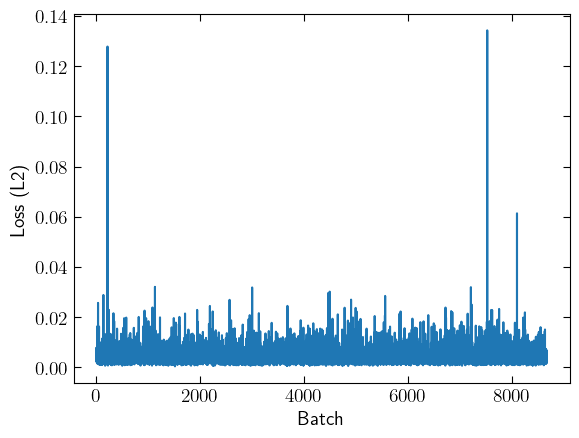

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004520 

Elapsed epoch time: 141.80 s
Epoch 8
-------------------------------
loss: 0.003344  [    0/277344]
loss: 0.005169  [ 8000/277344]
loss: 0.004729  [16000/277344]
loss: 0.004609  [24000/277344]
loss: 0.004640  [32000/277344]
loss: 0.004636  [40000/277344]
loss: 0.004617  [48000/277344]
loss: 0.004662  [56000/277344]
loss: 0.004636  [64000/277344]
loss: 0.004646  [72000/277344]
loss: 0.004694  [80000/277344]
loss: 0.004729  [88000/277344]
loss: 0.004740  [96000/277344]
loss: 0.004741  [104000/277344]
loss: 0.004744  [112000/277344]
loss: 0.004743  [120000/277344]
loss: 0.004756  [128000/277344]
loss: 0.004742  [136000/277344]
loss: 0.004718  [144000/277344]
loss: 0.004698  [152000/277344]
loss: 0.004685  [160000/277344]
loss: 0.004669  [168000/277344]
loss: 0.004673  [176000/277344]
loss: 0.004671  [184000/277344]
loss: 0.004664  [192000/277344]
loss: 0.004666  [200000/277344]
loss: 0.004675  [208000/277344]
loss: 0.004670  [216000/

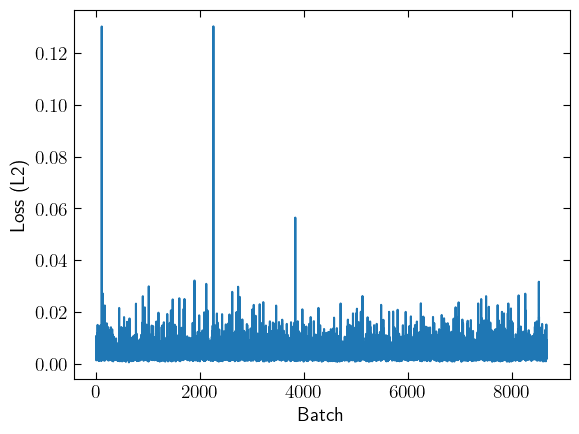

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004597 

Elapsed epoch time: 140.00 s
Epoch 9
-------------------------------
loss: 0.001500  [    0/277344]
loss: 0.004696  [ 8000/277344]
loss: 0.004735  [16000/277344]
loss: 0.004589  [24000/277344]
loss: 0.004732  [32000/277344]
loss: 0.004692  [40000/277344]
loss: 0.004646  [48000/277344]
loss: 0.004589  [56000/277344]
loss: 0.004571  [64000/277344]
loss: 0.004588  [72000/277344]
loss: 0.004575  [80000/277344]
loss: 0.004580  [88000/277344]
loss: 0.004664  [96000/277344]
loss: 0.004661  [104000/277344]
loss: 0.004625  [112000/277344]
loss: 0.004655  [120000/277344]
loss: 0.004651  [128000/277344]
loss: 0.004659  [136000/277344]
loss: 0.004635  [144000/277344]
loss: 0.004627  [152000/277344]
loss: 0.004624  [160000/277344]
loss: 0.004642  [168000/277344]
loss: 0.004633  [176000/277344]
loss: 0.004636  [184000/277344]
loss: 0.004639  [192000/277344]
loss: 0.004643  [200000/277344]
loss: 0.004644  [208000/277344]
loss: 0.004645  [216000/

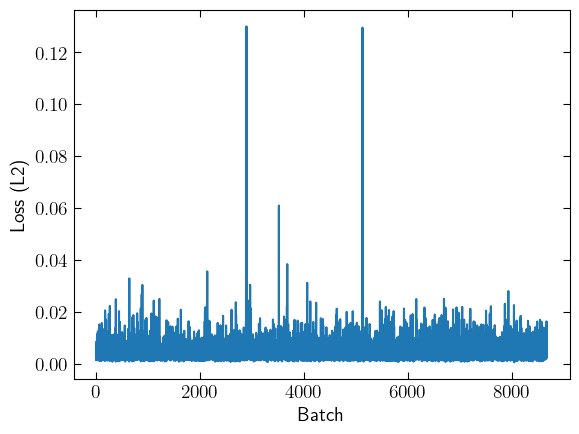

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004587 

Elapsed epoch time: 140.21 s
Epoch 10
-------------------------------
loss: 0.001316  [    0/277344]
loss: 0.004450  [ 8000/277344]
loss: 0.004472  [16000/277344]
loss: 0.004460  [24000/277344]
loss: 0.004557  [32000/277344]
loss: 0.004506  [40000/277344]
loss: 0.004530  [48000/277344]
loss: 0.004540  [56000/277344]
loss: 0.004512  [64000/277344]
loss: 0.004552  [72000/277344]
loss: 0.004547  [80000/277344]
loss: 0.004522  [88000/277344]
loss: 0.004564  [96000/277344]
loss: 0.004588  [104000/277344]
loss: 0.004618  [112000/277344]
loss: 0.004611  [120000/277344]
loss: 0.004612  [128000/277344]
loss: 0.004597  [136000/277344]
loss: 0.004588  [144000/277344]
loss: 0.004613  [152000/277344]
loss: 0.004624  [160000/277344]
loss: 0.004616  [168000/277344]
loss: 0.004625  [176000/277344]
loss: 0.004621  [184000/277344]
loss: 0.004611  [192000/277344]
loss: 0.004626  [200000/277344]
loss: 0.004637  [208000/277344]
loss: 0.004638  [216000

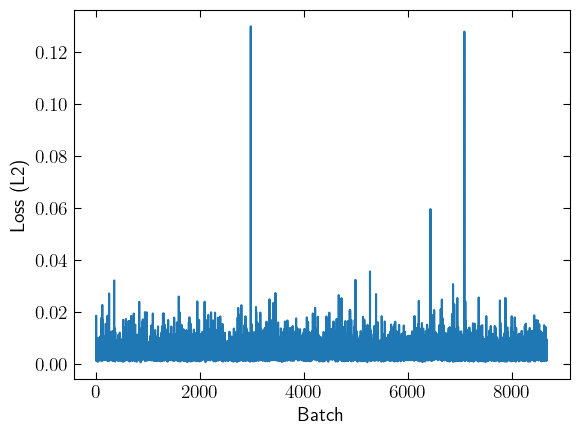

Test Error: 
 Accuracy: 0.000000%, Avg loss: 0.004567 

Elapsed epoch time: 139.26 s
Training completed


In [14]:
valloss = []
traloss = []
for t in range(epochs):
    t0 = time()
    print(f"Epoch {t+1}\n-------------------------------")
    trainloss = train(
        train_dataloader,
        model,
        loss_fn,
        optimizer,
        scheduler,
        device
    )
    if t % 25 == 0:
        validloss = valid(
            valid_dataloader,
            model,
            loss_fn,
            t,
            device,
            # plots = True,
        )
    else:
        validloss = valid(
            valid_dataloader,
            model,
            loss_fn,
            t,
            device,
        )
    # scheduler.step(validloss)
    valloss.append(validloss)
    traloss.append(trainloss)
    # torch.save({
    #             'epoch': t,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': tloss,
    #             }, '/arc/home/aydanmckay/ml/torchnn/checkpoints/checkpointWGLsmallepoch'+str(t)+'scalecutsep5.pth')
    # torch.save(model.state_dict(), "/arc/home/aydanmckay/torchmodel/torchmodelWsmallscalecutsep5iter"+str(t)+".pth")
    t1 = time()
    print(f'Elapsed epoch time: {t1-t0:.2f} s')
print("Training completed")

plotting the loss of each epoch

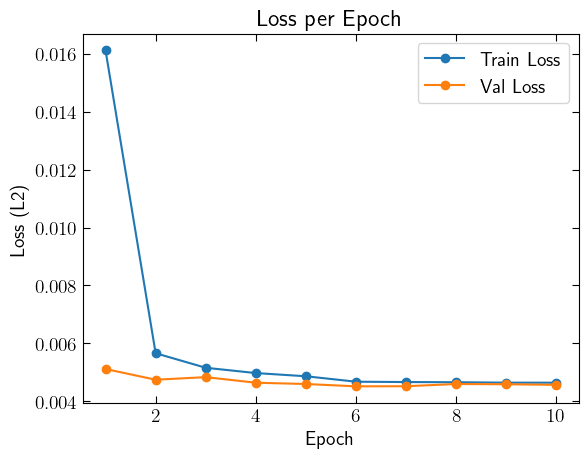

In [15]:
plt.plot(range(1,len(traloss)+1),traloss,'-o',label='Train Loss')
plt.plot(range(1,len(valloss)+1),valloss,'-o',label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss ('+lossname+')')
# plt.ylim(0.65,0.67)
plt.legend(fancybox=True)
plt.title('Loss per Epoch')
plt.savefig('/arc/home/aydanmckay/torchplots/plotloss_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

same but with log axis

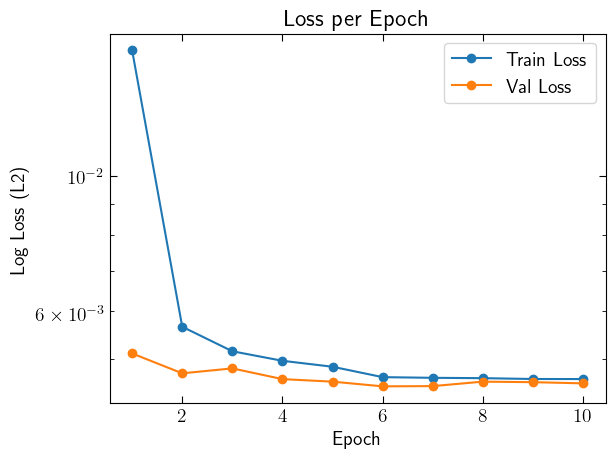

In [16]:
plt.semilogy(range(1,len(traloss)+1),traloss,'-o',label='Train Loss')
plt.semilogy(range(1,len(valloss)+1),valloss,'-o',label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss ('+lossname+')')
# plt.ylim(0.65,0.67)
plt.legend(fancybox=True)
plt.title('Loss per Epoch')
plt.savefig('/arc/home/aydanmckay/torchplots/semilogplotloss_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

saving the trained model

In [17]:
torch.save(model.state_dict(), '/arc/home/aydanmckay/torchmodel/rerun'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.pth')

loading the model to produce the comparison plot

In [22]:
model.load_state_dict(torch.load('/arc/home/aydanmckay/torchmodel/rerun'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.pth'))
model.eval()

ResNetM(
  (input_block): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (blocklist): ModuleList(
    (0): ResBlock(
      (res_block1): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (res_block2): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (lrelu): LeakyReLU(negative_slope=0.01)
      (siggy): Sigmoid()
      (do): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (res_block1): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
    

using the test data and the unscaled test data to see how the model is at predicting the bp/rp parameters. The comparison is done using the synthetic magnitudes so that we can test the fitting of every coefficient at once

plot residuals in reconstructed coeffs, first 3 for sure

In [23]:
test_data = data_set(datafname,train=False,valid=False,test=True,noscale=False)
test_dataloader = DataLoader(
    test_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)

putting the data into the correct format for inverse_scaling and gaiaxpy

In [24]:
unnormalize = lambda x, n: x * (10 ** (8.5 - n / 2.5))

In [25]:
# throw this into a class
def mag_generator(model,loaded_data):
    preds = []
    covbs = []
    covrs = []
    gs = []
    data = []
    with torch.no_grad():
        for X, y, g, z in loaded_data:
            X = X.to(device)
            y = y.to(device)
            g = g.to(device)
            z = z.to(device)
            pred = model(X)
            for prediction,gmag,err,dat in zip(pred,g,z,X):
                covbp = np.zeros((55,55))
                covrp = np.zeros((55,55))
                gs.append(gmag)
                preds.append(prediction)
                data.append(dat)
#                 checking to make sure that the prior errors aren't required for the prediction of magnitude
                # for it in range(len(err[:55])):
                #     covbp[it][it] += err[it].item()**2
                #     covrp[it][it] += err[it+55].item()**2
                covbs.append(covbp)
                covrs.append(covrp)
    preds = np.array([pred.to('cpu').numpy() for pred in preds]).T
    gs = np.array([g.to('cpu').numpy() for g in gs]).T
    data = np.array([dat.to('cpu').numpy() for dat in data]).T
    xpcoefs = np.array([unnormalize(row,mag) for row,mag in zip(preds.T,gs)]).T

    bpnews = np.array(xpcoefs[:55]).T
    rpnews = np.array(xpcoefs[55:]).T
    df = pd.DataFrame(
        {'source_id':range(len(preds.T)),
         'bp_coefficients':list(bpnews),
         'bp_standard_deviation':[np.std(bp) for bp in bpnews],
         'bp_coefficient_covariances':covbs,
         'rp_coefficients':list(rpnews),
         'rp_coefficient_covariances':covrs,
         'rp_standard_deviation':[np.std(rp) for rp in rpnews]
        }
    )
    # print(df)
    # synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
    synthetic_photometry = generate(df, photometric_system=PhotometricSystem.SDSS)
    return synthetic_photometry, bpnews, rpnews, data

generating the synthetic magnitudes of the predicted coeffs that were then inverse_scaled

In [26]:
test_synth_phot_preds, test_bp_preds, test_rp_preds, test_data_preds = mag_generator(model,test_dataloader)

In [27]:
test_synth_phot_preds

source_id  Sdss_mag_u  Sdss_mag_g  Sdss_mag_r  Sdss_mag_i  Sdss_mag_z  \
0              0   13.697918   11.874563   10.998332   10.671173   10.465265   
1              1   14.652949   13.288804   12.757415   12.591630   12.552073   
2              2   14.385542   12.991527   12.395012   12.200733   12.118882   
3              3   16.380922   14.579393   13.074178   12.467275   12.019990   
4              4   15.125227   13.332972   12.525743   12.261319   12.101653   
...          ...         ...         ...         ...         ...         ...   
34236      34236   12.709772   11.442143   10.993441   10.838170   10.780110   
34237      34237   13.296345   11.979200   11.445579   11.278457   11.227011   
34238      34238   16.949159   15.121579   14.158031   13.792390   13.546598   
34239      34239   18.369063   16.461973   14.734121   13.712410   13.057200   
34240      34240   14.446028   12.556707   11.502103   11.106155   10.839513   

        Sdss_flux_u   Sdss_flux_g   Sdss_flux_r   Sdss_flux_i   Sdss_flux_z  \
0      1.204572e-28  6.459144e-28  1.447662e-27  1.956729e-27  2.365342e-27   
1      4.998276e-29  1.755814e-28  2.864403e-28  3.336936e-28  3.460753e-28   
2      6.394156e-29  2.308815e-28  3.999403e-28  4.783073e-28  5.157596e-28   
3      1.017727e-29  5.348634e-29  2.139581e-28  3.741882e-28  5.649423e-28   
4      3.235261e-29  1.685819e-28  3.545707e-28  4.523479e-28  5.240092e-28   
...             ...           ...           ...           ...           ...   
34236  2.992894e-28  9.619286e-28  1.454198e-27  1.677768e-27  1.769929e-27   
34237  1.743661e-28  5.865701e-28  9.588889e-28  1.118452e-27  1.172724e-27   
34238  6.030266e-30  3.246149e-29  7.884742e-29  1.104190e-28  1.384716e-28   
34239  1.630703e-30  9.445193e-30  4.638223e-29  1.188601e-28  2.173302e-28   
34240  6.047678e-29  3.446016e-28  9.102457e-28  1.310804e-27  1.675694e-27   

       Sdss_flux_error_u  Sdss_flux_error_g  Sdss_flux_error_r  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
34236                0.0                0.0                0.0   
34237                0.0                0.0                0.0   
34238                0.0                0.0                0.0   
34239                0.0                0.0                0.0   
34240                0.0                0.0                0.0   

       Sdss_flux_error_i  Sdss_flux_error_z  
0                    0.0                0.0  
1                    0.0                0.0  
2                    0.0                0.0  
3                    0.0                0.0  
4                    0.0                0.0  
...                  ...                ...  
34236                0.0                0.0  
34237                0.0                0.0  
34238                0.0                0.0  
34239                0.0                0.0  
34240                0.0                0.0  

[34241 rows x 16 columns]

putting the unscaled test data into the correct format for gaiaxpy

In [28]:
# # throw this into a class
def mag_generator_unscaled(model,loaded_data):
    preds = []
    data = []
    covbs = []
    covrs = [] 
    with torch.no_grad():
        for X, y, g, z in loaded_data:
            X = X.to(device)
            y = y.to(device)
            z = z.to(device)
            pred = y             
            for prediction,err,dat in zip(pred,z,X):
                covbp = np.zeros((55,55))
                covrp = np.zeros((55,55))
                preds.append(prediction)
                data.append(dat)              
#                 checking to make sure that the prior errors aren't required for the prediction of magnitude
                # for it in range(len(err[:55])):
                    # covbp[it][it] += err[it].item()**2
                    # covrp[it][it] += err[it+55].item()**2
                covbs.append(covbp)
                covrs.append(covrp)
    preds = np.array([pred.to('cpu').numpy() for pred in preds]).T     
    data = np.array([dat.to('cpu').numpy() for dat in data]).T
    bpnews = np.array(preds[:55]).T
    rpnews = np.array(preds[55:]).T
    df = pd.DataFrame(
        {'source_id':range(len(preds.T)),
         'bp_coefficients':list(bpnews),
         'bp_standard_deviation':[np.std(bp) for bp in bpnews],
         'bp_coefficient_covariances':covbs,
         'rp_coefficients':list(rpnews),
         'rp_coefficient_covariances':covrs,
         'rp_standard_deviation':[np.std(rp) for rp in rpnews]
        }
    )
    # synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
    synthetic_photometry = generate(df, photometric_system=PhotometricSystem.SDSS)
    return synthetic_photometry, bpnews, rpnews, data

generating the synthetic magnitudes of the true coeffs

In [29]:
test_synth_phot_trues, test_bp_trues, test_rp_trues, test_data_trues = mag_generator_unscaled(model,test_dataloader)

In [30]:
test_synth_phot_trues.describe()

source_id    Sdss_mag_u    Sdss_mag_g    Sdss_mag_r    Sdss_mag_i  \
count  34241.00000  34112.000000  34238.000000  34241.000000  34241.000000   
mean   17120.00000     15.264151     13.543356     12.574346     12.206458   
std     9884.66962      1.985123      1.800073      1.505760      1.370285   
min        0.00000      8.552933      7.412068      7.290345      7.289790   
25%     8560.00000     13.911483     12.363704     11.602634     11.330669   
50%    17120.00000     15.152157     13.379465     12.512987     12.220520   
75%    25680.00000     16.548671     14.636841     13.498033     13.063157   
max    34240.00000     25.865806     24.296996     19.946624     17.303578   

         Sdss_mag_z   Sdss_flux_u   Sdss_flux_g   Sdss_flux_r   Sdss_flux_i  \
count  34241.000000  3.424100e+04  3.424100e+04  3.424100e+04  3.424100e+04   
mean      11.989535  1.249283e-28  4.525476e-28  8.284879e-28  1.043048e-27   
std        1.296446  3.841956e-28  1.113205e-27  1.575300e-27  1.806547e-27   
min        7.275802 -7.068606e-31 -3.019968e-32  3.813734e-31  4.350795e-30   
25%       11.164733  8.588808e-30  5.070197e-29  1.448060e-28  2.161410e-28   
50%       12.043066  3.134490e-29  1.614962e-28  3.587608e-28  4.696690e-28   
75%       12.800079  9.849782e-29  4.116030e-28  8.297483e-28  1.065939e-27   
max       16.266258  1.376660e-26  3.937068e-26  4.404149e-26  4.406399e-26   

        Sdss_flux_z  Sdss_flux_error_u  Sdss_flux_error_g  Sdss_flux_error_r  \
count  3.424100e+04            34241.0            34241.0            34241.0   
mean   1.197312e-27                0.0                0.0                0.0   
std    1.939191e-27                0.0                0.0                0.0   
min    1.131089e-29                0.0                0.0                0.0   
25%    2.754029e-28                0.0                0.0                0.0   
50%    5.530619e-28                0.0                0.0                0.0   
75%    1.241958e-27                0.0                0.0                0.0   
max    4.463537e-26                0.0                0.0                0.0   

       Sdss_flux_error_i  Sdss_flux_error_z  
count            34241.0            34241.0  
mean                 0.0                0.0  
std                  0.0                0.0  
min                  0.0                0.0  
25%                  0.0                0.0  
50%                  0.0                0.0  
75%                  0.0                0.0  
max                  0.0                0.0

In [31]:
test_synth_phot_trues.describe()

source_id    Sdss_mag_u    Sdss_mag_g    Sdss_mag_r    Sdss_mag_i  \
count  34241.00000  34112.000000  34238.000000  34241.000000  34241.000000   
mean   17120.00000     15.264151     13.543356     12.574346     12.206458   
std     9884.66962      1.985123      1.800073      1.505760      1.370285   
min        0.00000      8.552933      7.412068      7.290345      7.289790   
25%     8560.00000     13.911483     12.363704     11.602634     11.330669   
50%    17120.00000     15.152157     13.379465     12.512987     12.220520   
75%    25680.00000     16.548671     14.636841     13.498033     13.063157   
max    34240.00000     25.865806     24.296996     19.946624     17.303578   

         Sdss_mag_z   Sdss_flux_u   Sdss_flux_g   Sdss_flux_r   Sdss_flux_i  \
count  34241.000000  3.424100e+04  3.424100e+04  3.424100e+04  3.424100e+04   
mean      11.989535  1.249283e-28  4.525476e-28  8.284879e-28  1.043048e-27   
std        1.296446  3.841956e-28  1.113205e-27  1.575300e-27  1.806547e-27   
min        7.275802 -7.068606e-31 -3.019968e-32  3.813734e-31  4.350795e-30   
25%       11.164733  8.588808e-30  5.070197e-29  1.448060e-28  2.161410e-28   
50%       12.043066  3.134490e-29  1.614962e-28  3.587608e-28  4.696690e-28   
75%       12.800079  9.849782e-29  4.116030e-28  8.297483e-28  1.065939e-27   
max       16.266258  1.376660e-26  3.937068e-26  4.404149e-26  4.406399e-26   

        Sdss_flux_z  Sdss_flux_error_u  Sdss_flux_error_g  Sdss_flux_error_r  \
count  3.424100e+04            34241.0            34241.0            34241.0   
mean   1.197312e-27                0.0                0.0                0.0   
std    1.939191e-27                0.0                0.0                0.0   
min    1.131089e-29                0.0                0.0                0.0   
25%    2.754029e-28                0.0                0.0                0.0   
50%    5.530619e-28                0.0                0.0                0.0   
75%    1.241958e-27                0.0                0.0                0.0   
max    4.463537e-26                0.0                0.0                0.0   

       Sdss_flux_error_i  Sdss_flux_error_z  
count            34241.0            34241.0  
mean                 0.0                0.0  
std                  0.0                0.0  
min                  0.0                0.0  
25%                  0.0                0.0  
50%                  0.0                0.0  
75%                  0.0                0.0  
max                  0.0                0.0

In [32]:
test_synth_phot_preds.describe()

source_id    Sdss_mag_u    Sdss_mag_g    Sdss_mag_r    Sdss_mag_i  \
count  34241.00000  34162.000000  34231.000000  34241.000000  34241.000000   
mean   17120.00000     15.238312     13.504982     12.567197     12.206808   
std     9884.66962      1.844717      1.643089      1.465117      1.396985   
min        0.00000      8.539323      7.519457      7.305443      7.242988   
25%     8560.00000     13.990479     12.425650     11.624042     11.313561   
50%    17120.00000     15.145518     13.404196     12.521589     12.208006   
75%    25680.00000     16.452459     14.565571     13.489971     13.081058   
max    34240.00000     24.921328     21.368267     18.712080     17.545199   

         Sdss_mag_z   Sdss_flux_u   Sdss_flux_g   Sdss_flux_r   Sdss_flux_i  \
count  34241.000000  3.424100e+04  3.424100e+04  3.424100e+04  3.424100e+04   
mean      11.983040  1.137283e-28  4.217224e-28  8.154618e-28  1.068028e-27   
std        1.365387  3.457219e-28  1.016881e-27  1.553820e-27  1.880015e-27   
min        7.266250 -1.434648e-29 -1.842528e-30  1.188963e-30  3.482736e-30   
25%       11.115905  9.441221e-30  5.413039e-29  1.458853e-28  2.126066e-28   
50%       12.020081  3.159726e-29  1.577586e-28  3.559300e-28  4.751139e-28   
75%       12.823986  9.179118e-29  3.886623e-28  8.135484e-28  1.082868e-27   
max       17.590751  1.394026e-26  3.566294e-26  4.343328e-26  4.600498e-26   

        Sdss_flux_z  Sdss_flux_error_u  Sdss_flux_error_g  Sdss_flux_error_r  \
count  3.424100e+04            34241.0            34241.0            34241.0   
mean   1.278693e-27                0.0                0.0                0.0   
std    2.146341e-27                0.0                0.0                0.0   
min    3.339641e-30                0.0                0.0                0.0   
25%    2.694049e-28                0.0                0.0                0.0   
50%    5.648949e-28                0.0                0.0                0.0   
75%    1.299086e-27                0.0                0.0                0.0   
max    4.502981e-26                0.0                0.0                0.0   

       Sdss_flux_error_i  Sdss_flux_error_z  
count            34241.0            34241.0  
mean                 0.0                0.0  
std                  0.0                0.0  
min                  0.0                0.0  
25%                  0.0                0.0  
50%                  0.0                0.0  
75%                  0.0                0.0  
max                  0.0                0.0

Plotting the comparison plot

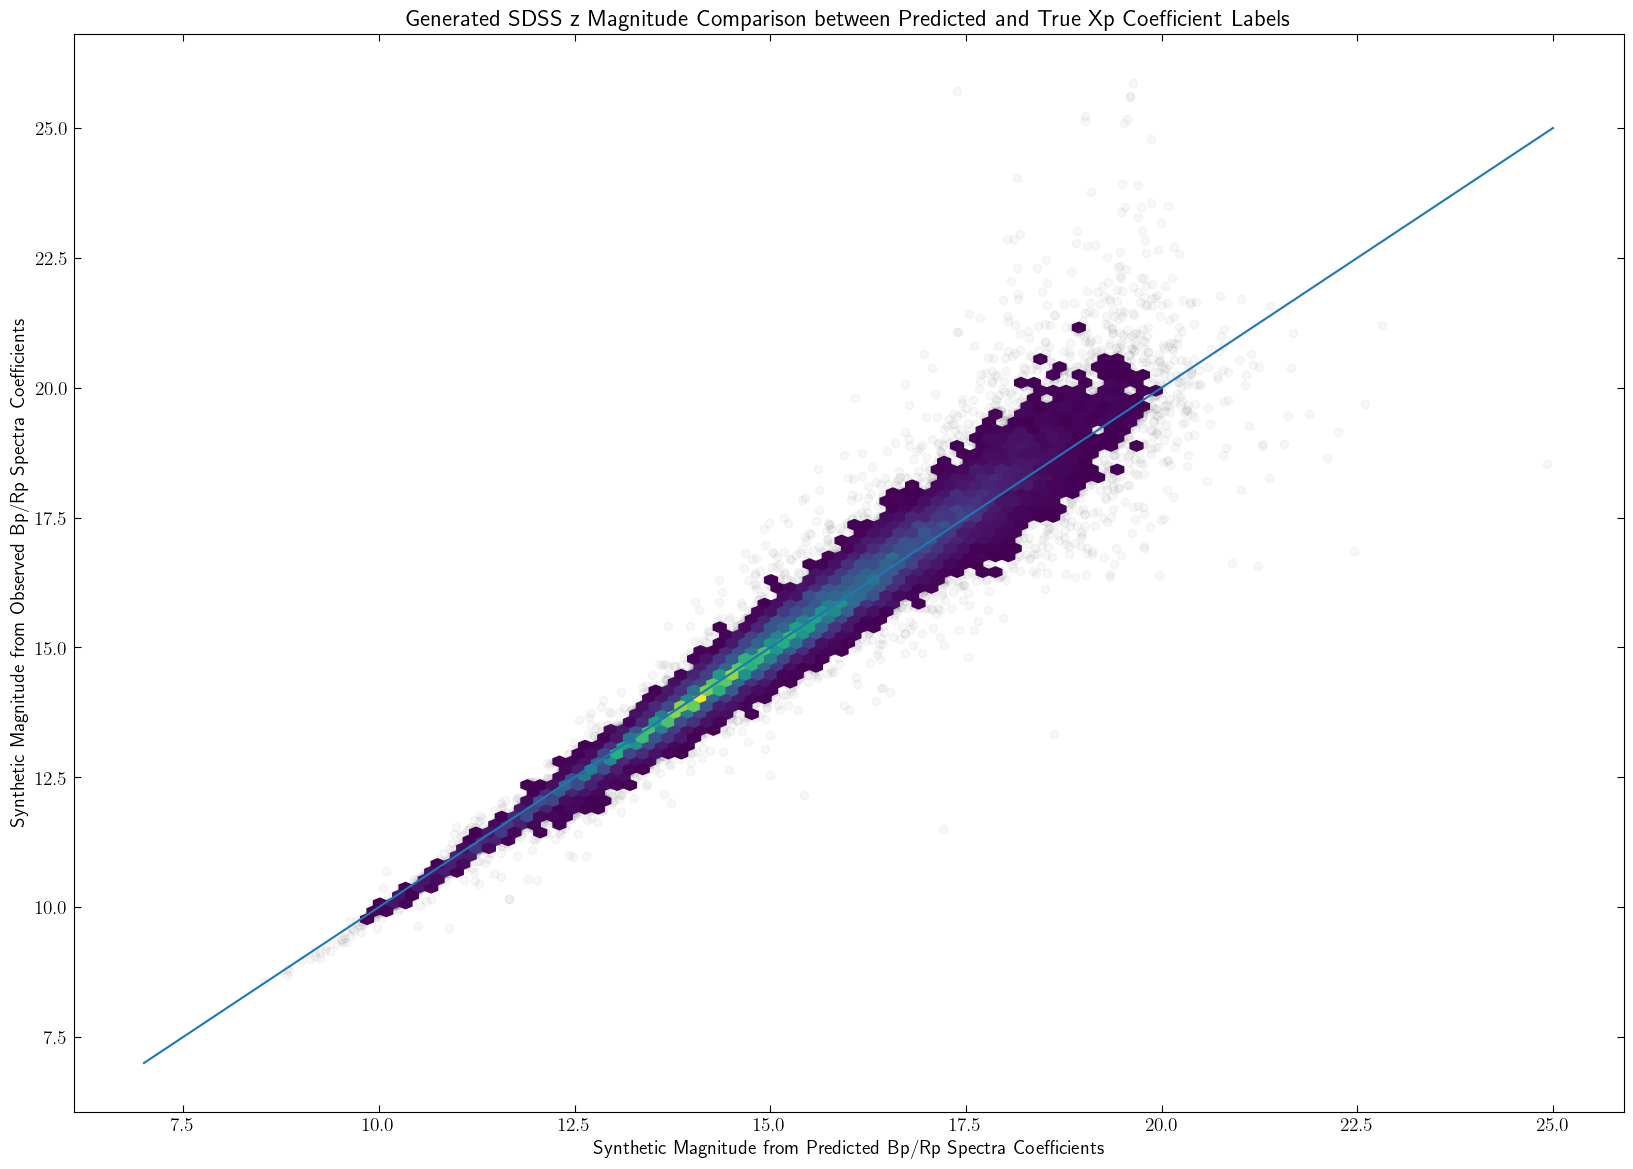

In [40]:
plt.figure(figsize=(20,14))

ax = plt.gca()
# ax.xaxis.set_minor_locator(MultipleLocator(200))
# ax.yaxis.set_minor_locator(MultipleLocator(.2))

# plt.scatter(test_synth_phot_preds['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK'],c='k',alpha=0.03)
# plt.hexbin(test_synth_phot_preds['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK'],mincnt=5)
plt.scatter(test_synth_phot_preds['Sdss_mag_u'],test_synth_phot_trues['Sdss_mag_u'],c='k',alpha=0.03)
plt.hexbin(test_synth_phot_preds['Sdss_mag_u'],test_synth_phot_trues['Sdss_mag_u'],mincnt=5)
plt.plot(np.arange(7,26),np.arange(7,26))
# plt.xlim(13,26)
plt.xlabel('Synthetic Magnitude from Predicted Bp/Rp Spectra Coefficients')
plt.ylabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
# plt.title('Generated Pristine CaHK Magnitude Comparison between Predicted and True Xp Coefficient Labels');
plt.title('Generated SDSS z Magnitude Comparison between Predicted and True Xp Coefficient Labels');
# plt.savefig('/arc/home/aydanmckay/torchplots/testaccuracy_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

Text(0.5, 0, 'Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')

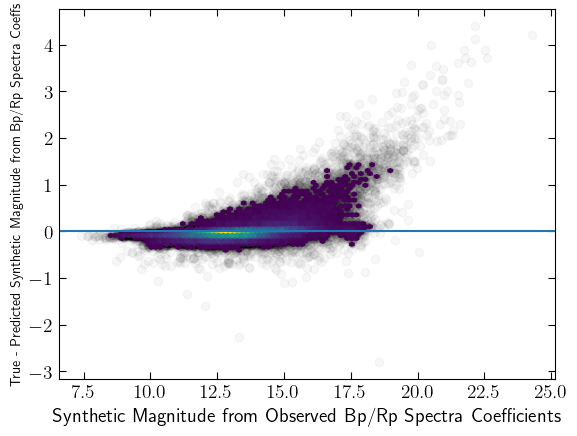

In [35]:
# plt.scatter(test_synth_phot_trues['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK'],c='k',alpha=0.03)
# plt.hexbin(test_synth_phot_trues['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK'],mincnt=5)
plt.scatter(test_synth_phot_trues['Sdss_mag_g'],test_synth_phot_trues['Sdss_mag_g']-test_synth_phot_preds['Sdss_mag_g'],c='k',alpha=0.03)
plt.hexbin(test_synth_phot_trues['Sdss_mag_g'],test_synth_phot_trues['Sdss_mag_g']-test_synth_phot_preds['Sdss_mag_g'],mincnt=5)
plt.axhline()
plt.ylabel('True - Predicted Synthetic Magnitude from Bp/Rp Spectra Coeffs',fontsize=10)
plt.xlabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
# plt.savefig('/arc/home/aydanmckay/torchplots/testresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

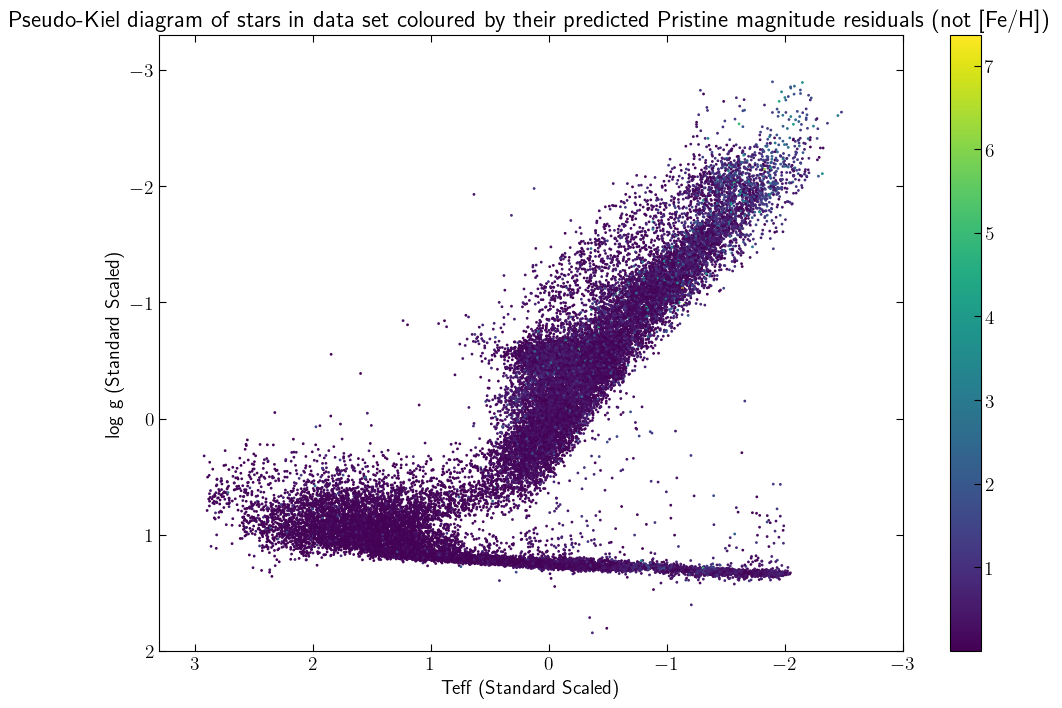

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2],test_data_preds[1],c=abs(test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK']),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals (not [Fe/H])')
plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

Text(0.5, 1.0, 'Kiel diagram of stars in data set')

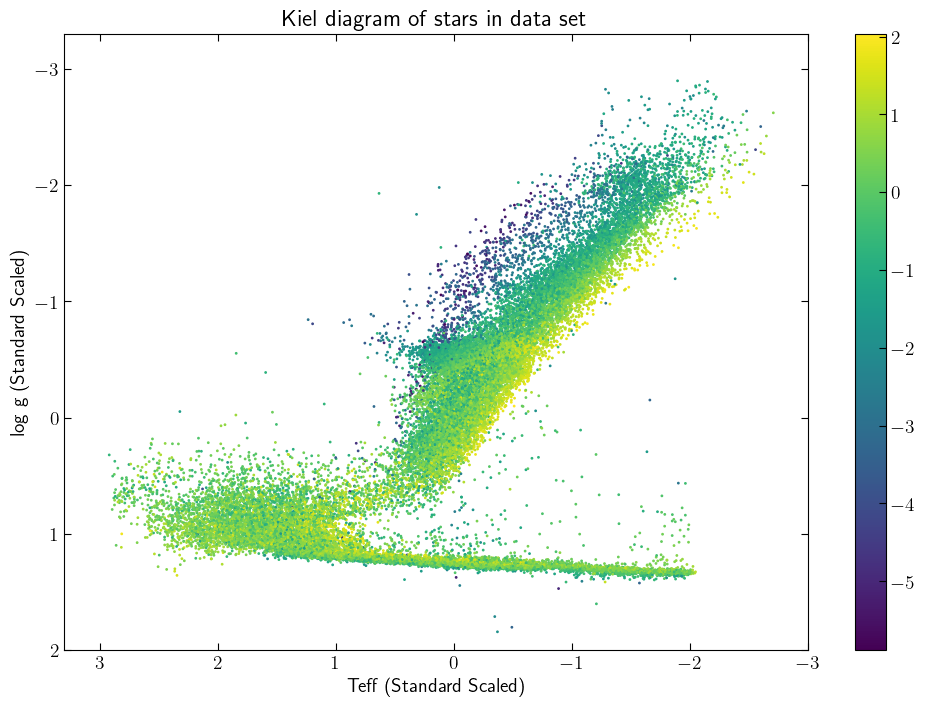

In [43]:
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2],test_data_preds[1],c=test_data_preds[0],s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Kiel diagram of stars in data set')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

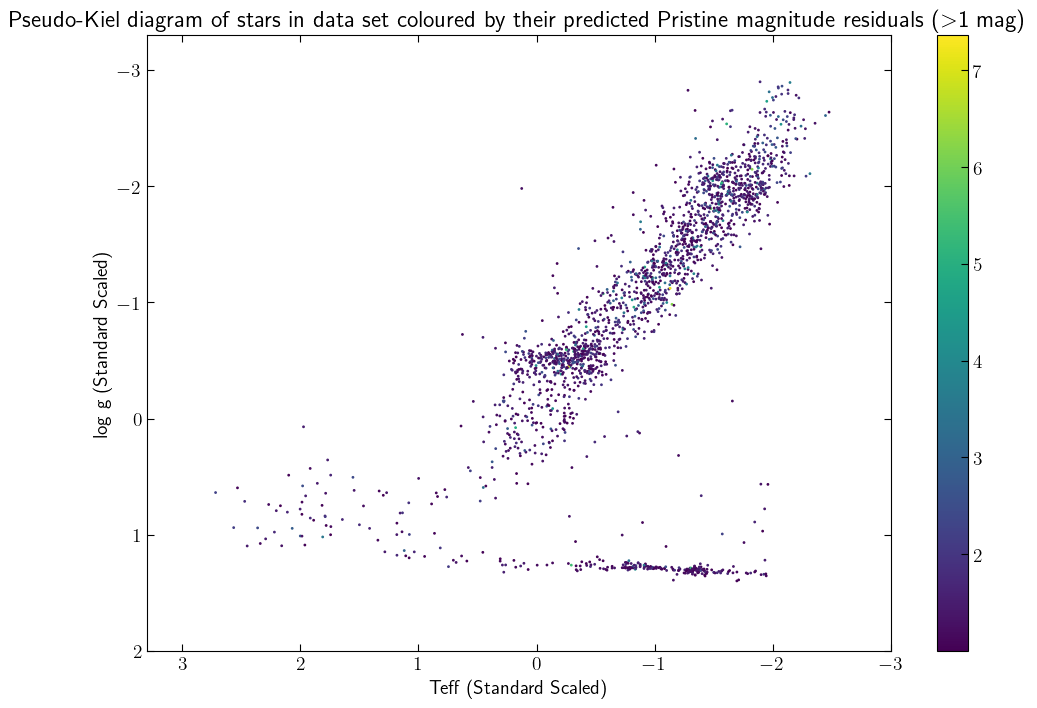

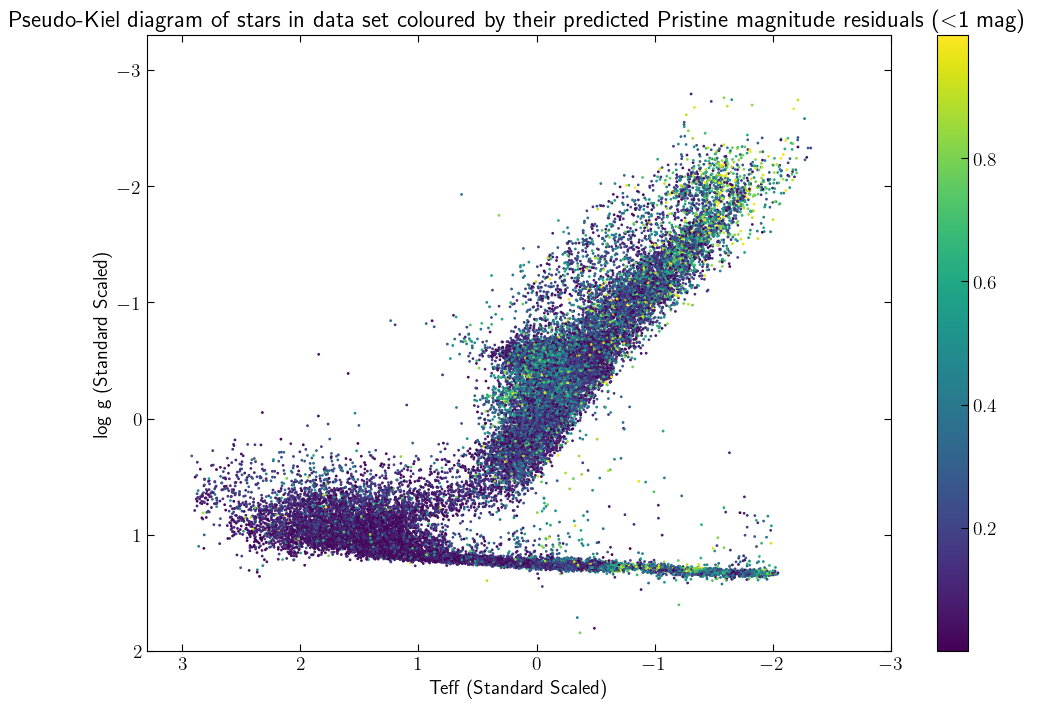

In [32]:
mask = abs(test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK']) > 1
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][mask],test_data_preds[1][mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][mask]-test_synth_phot_preds['Pristine_mag_CaHK'][mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($>$1 mag)')
plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagrambadresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][~mask],test_data_preds[1][~mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][~mask]-test_synth_phot_preds['Pristine_mag_CaHK'][~mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($<$1 mag)')
plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramgoodresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

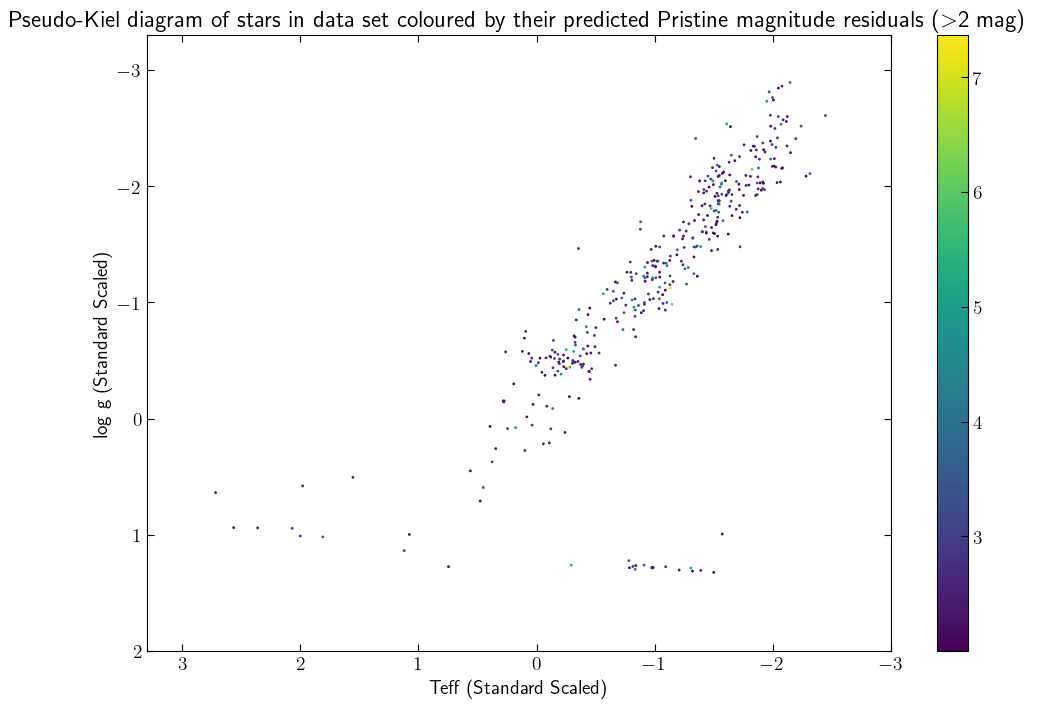

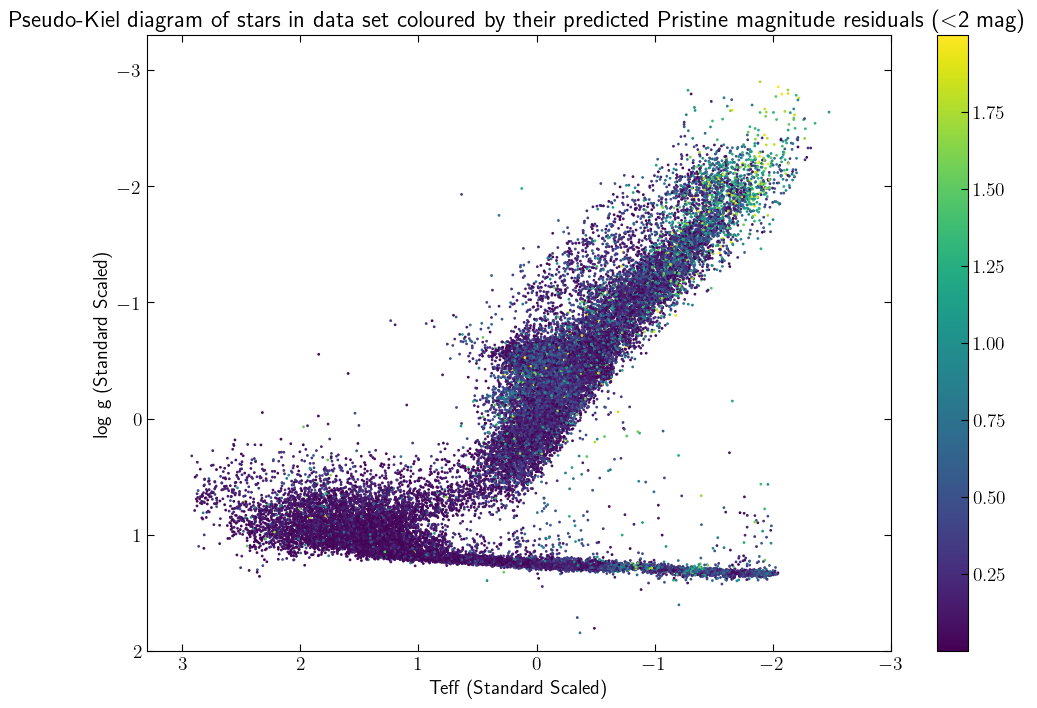

In [33]:
mask = abs(test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK']) > 2
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][mask],test_data_preds[1][mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][mask]-test_synth_phot_preds['Pristine_mag_CaHK'][mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($>$2 mag)')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagrambadresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][~mask],test_data_preds[1][~mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][~mask]-test_synth_phot_preds['Pristine_mag_CaHK'][~mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($<$2 mag)')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramgoodresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

once the fit is better

get the g mag of all the samples,

plot the distribution of the training sample in g

arc/home/aydanmckay/torchresmodel/trainedmodel_filteredapogeelossL1MLP_Powerbl32lr0.01SGDep2dropout.pth is a model with a decent residual plot but a worse looking accuracy plot when using the filtered apogee and the power transformer

In [41]:
train2_dataloader = DataLoader(
    training_data,
    batch_size=batchlen,
    shuffle=False,
    num_workers=0
)

train_synth_phot_preds, train_bp_preds, train_rp_preds, train_data_preds = mag_generator(model,train2_dataloader)
train_synth_phot_trues, train_bp_trues, train_rp_trues, train_data_trues = mag_generator_unscaled(model,train2_dataloader)

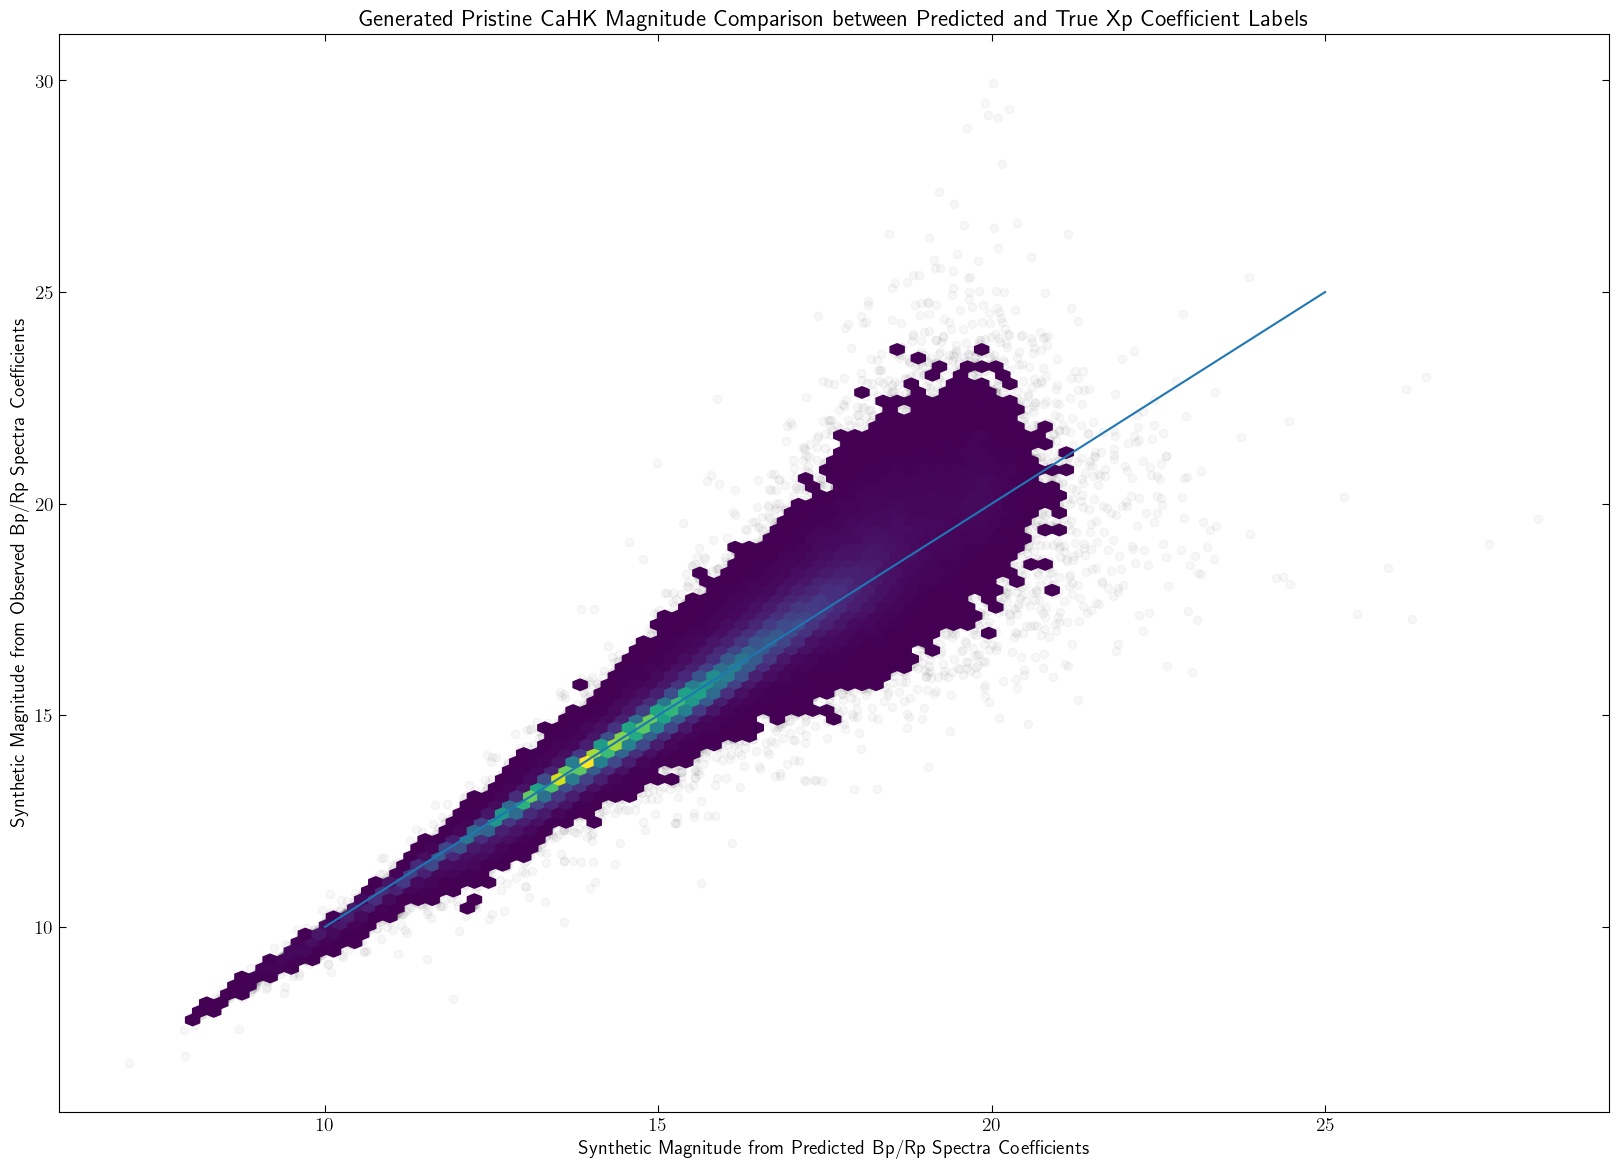

In [42]:
plt.figure(figsize=(20,14))

ax = plt.gca()
# ax.xaxis.set_minor_locator(MultipleLocator(200))
# ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.scatter(train_synth_phot_preds['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK'],c='k',alpha=0.03)
plt.hexbin(train_synth_phot_preds['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK'],mincnt=5)
plt.plot(np.arange(7,26),np.arange(7,26))
# plt.xlim(13,26)
plt.xlabel('Synthetic Magnitude from Predicted Bp/Rp Spectra Coefficients')
plt.ylabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
plt.title('Generated Pristine CaHK Magnitude Comparison between Predicted and True Xp Coefficient Labels');
plt.savefig('/arc/home/aydanmckay/torchplots/trainaccuracy_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

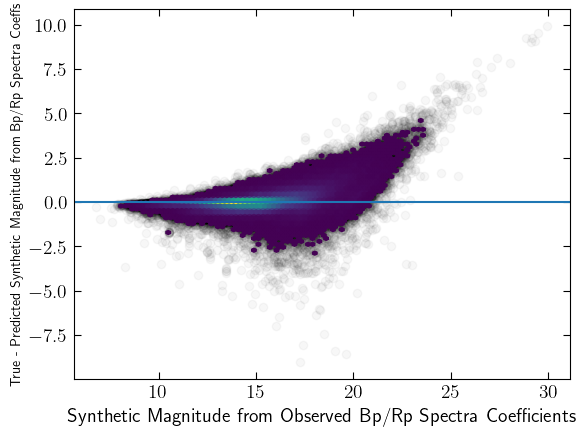

In [43]:
plt.scatter(train_synth_phot_trues['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK']-train_synth_phot_preds['Pristine_mag_CaHK'],c='k',alpha=0.03)
plt.hexbin(train_synth_phot_trues['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK']-train_synth_phot_preds['Pristine_mag_CaHK'],mincnt=5)
plt.axhline()
plt.ylabel('True - Predicted Synthetic Magnitude from Bp/Rp Spectra Coeffs',fontsize=10)
plt.xlabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
plt.savefig('/arc/home/aydanmckay/torchplots/trainresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

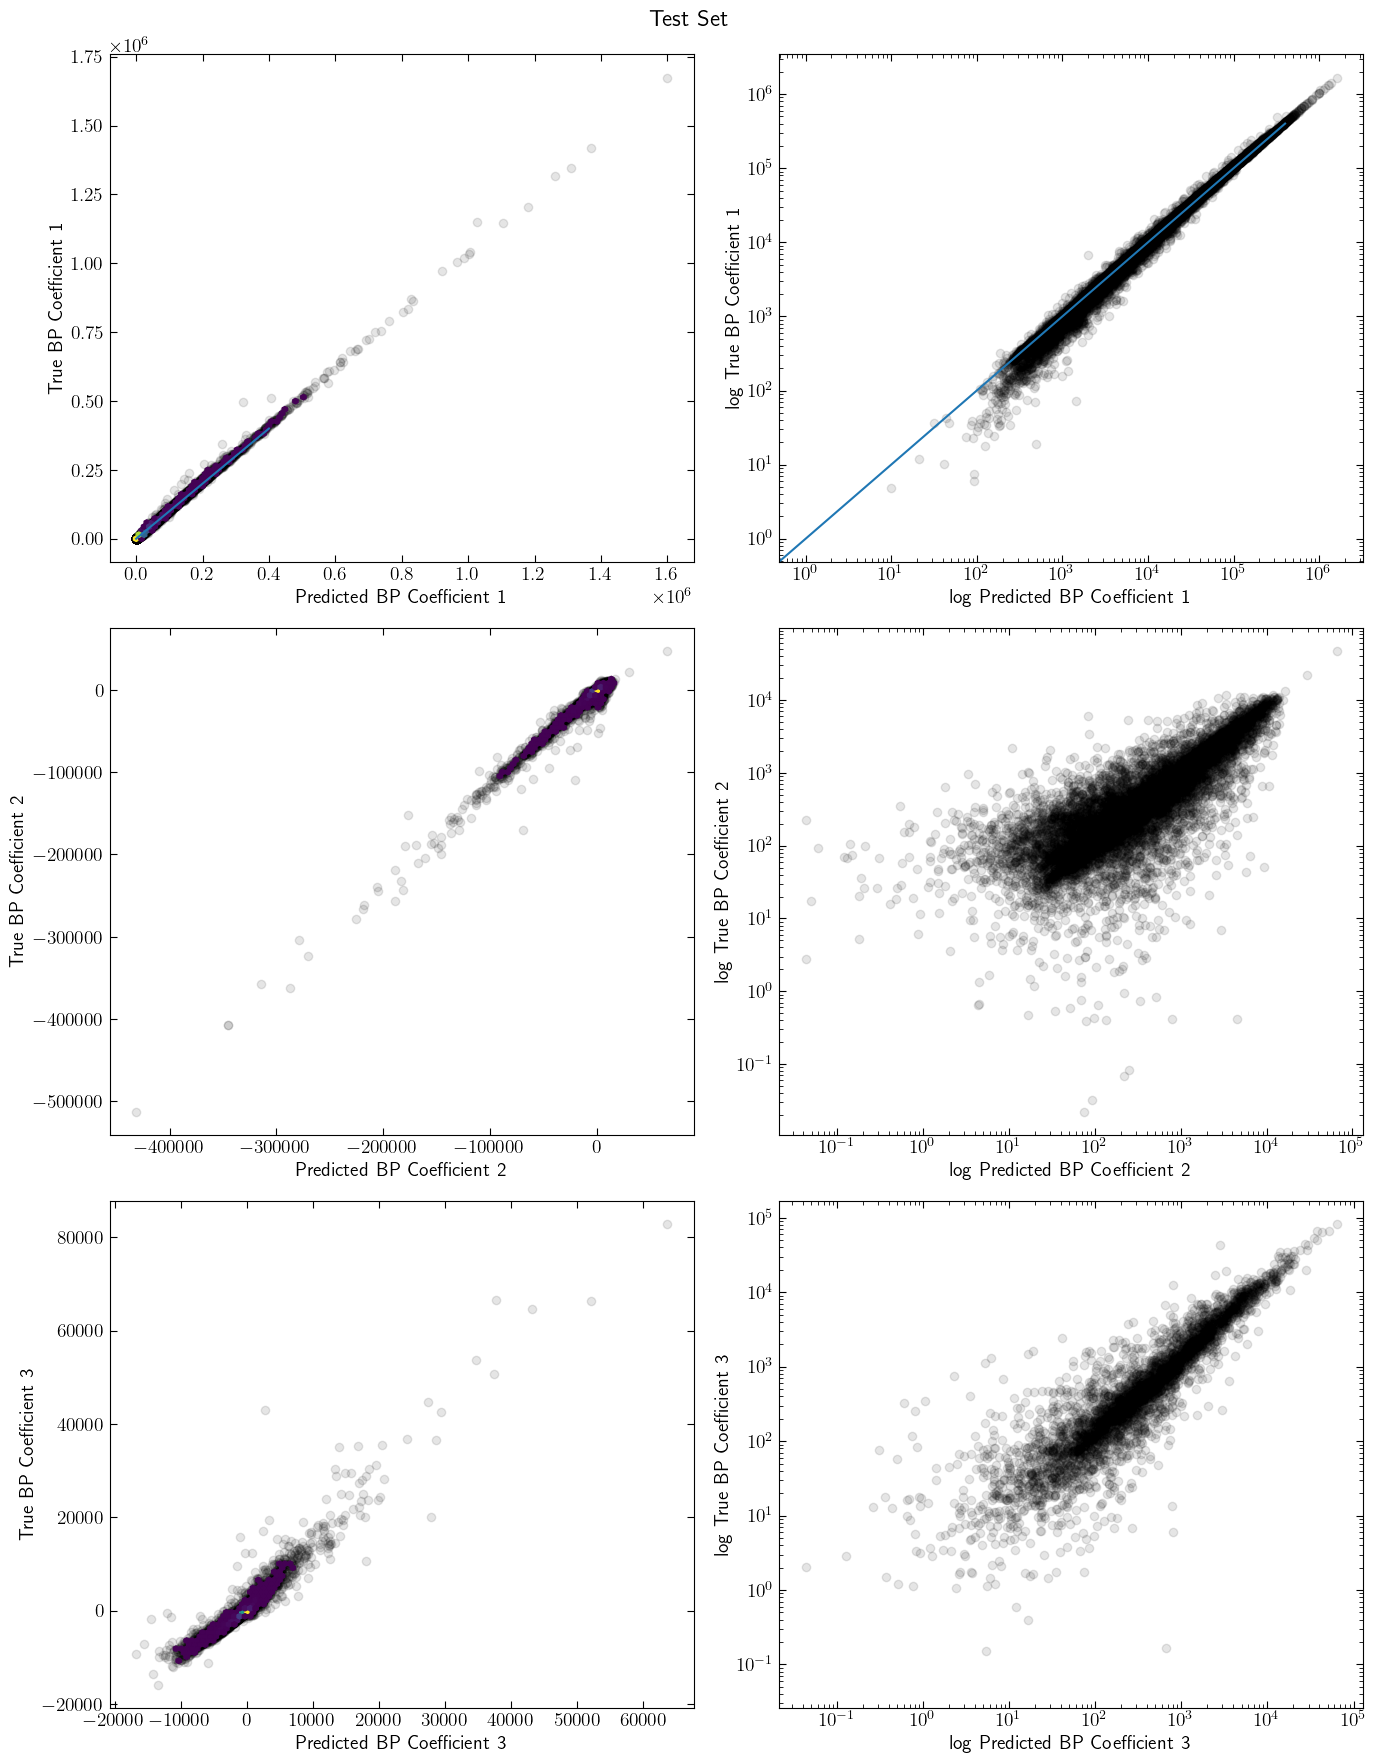

In [44]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Test Set')
axs[0,0].scatter(test_bp_preds[:,0],test_bp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(test_bp_preds[:,0],test_bp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True BP Coefficient 1')
axs[0,0].set_xlabel('Predicted BP Coefficient 1');
axs[0,1].scatter(test_bp_preds[:,0],test_bp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True BP Coefficient 1')
axs[0,1].set_xlabel('log Predicted BP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(test_bp_preds[:,1],test_bp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(test_bp_preds[:,1],test_bp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True BP Coefficient 2')
axs[1,0].set_xlabel('Predicted BP Coefficient 2');
axs[1,1].scatter(test_bp_preds[:,1],test_bp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True BP Coefficient 2')
axs[1,1].set_xlabel('log Predicted BP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(test_bp_preds[:,2],test_bp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(test_bp_preds[:,2],test_bp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True BP Coefficient 3')
axs[2,0].set_xlabel('Predicted BP Coefficient 3');
axs[2,1].scatter(test_bp_preds[:,2],test_bp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True BP Coefficient 3')
axs[2,1].set_xlabel('log Predicted BP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()

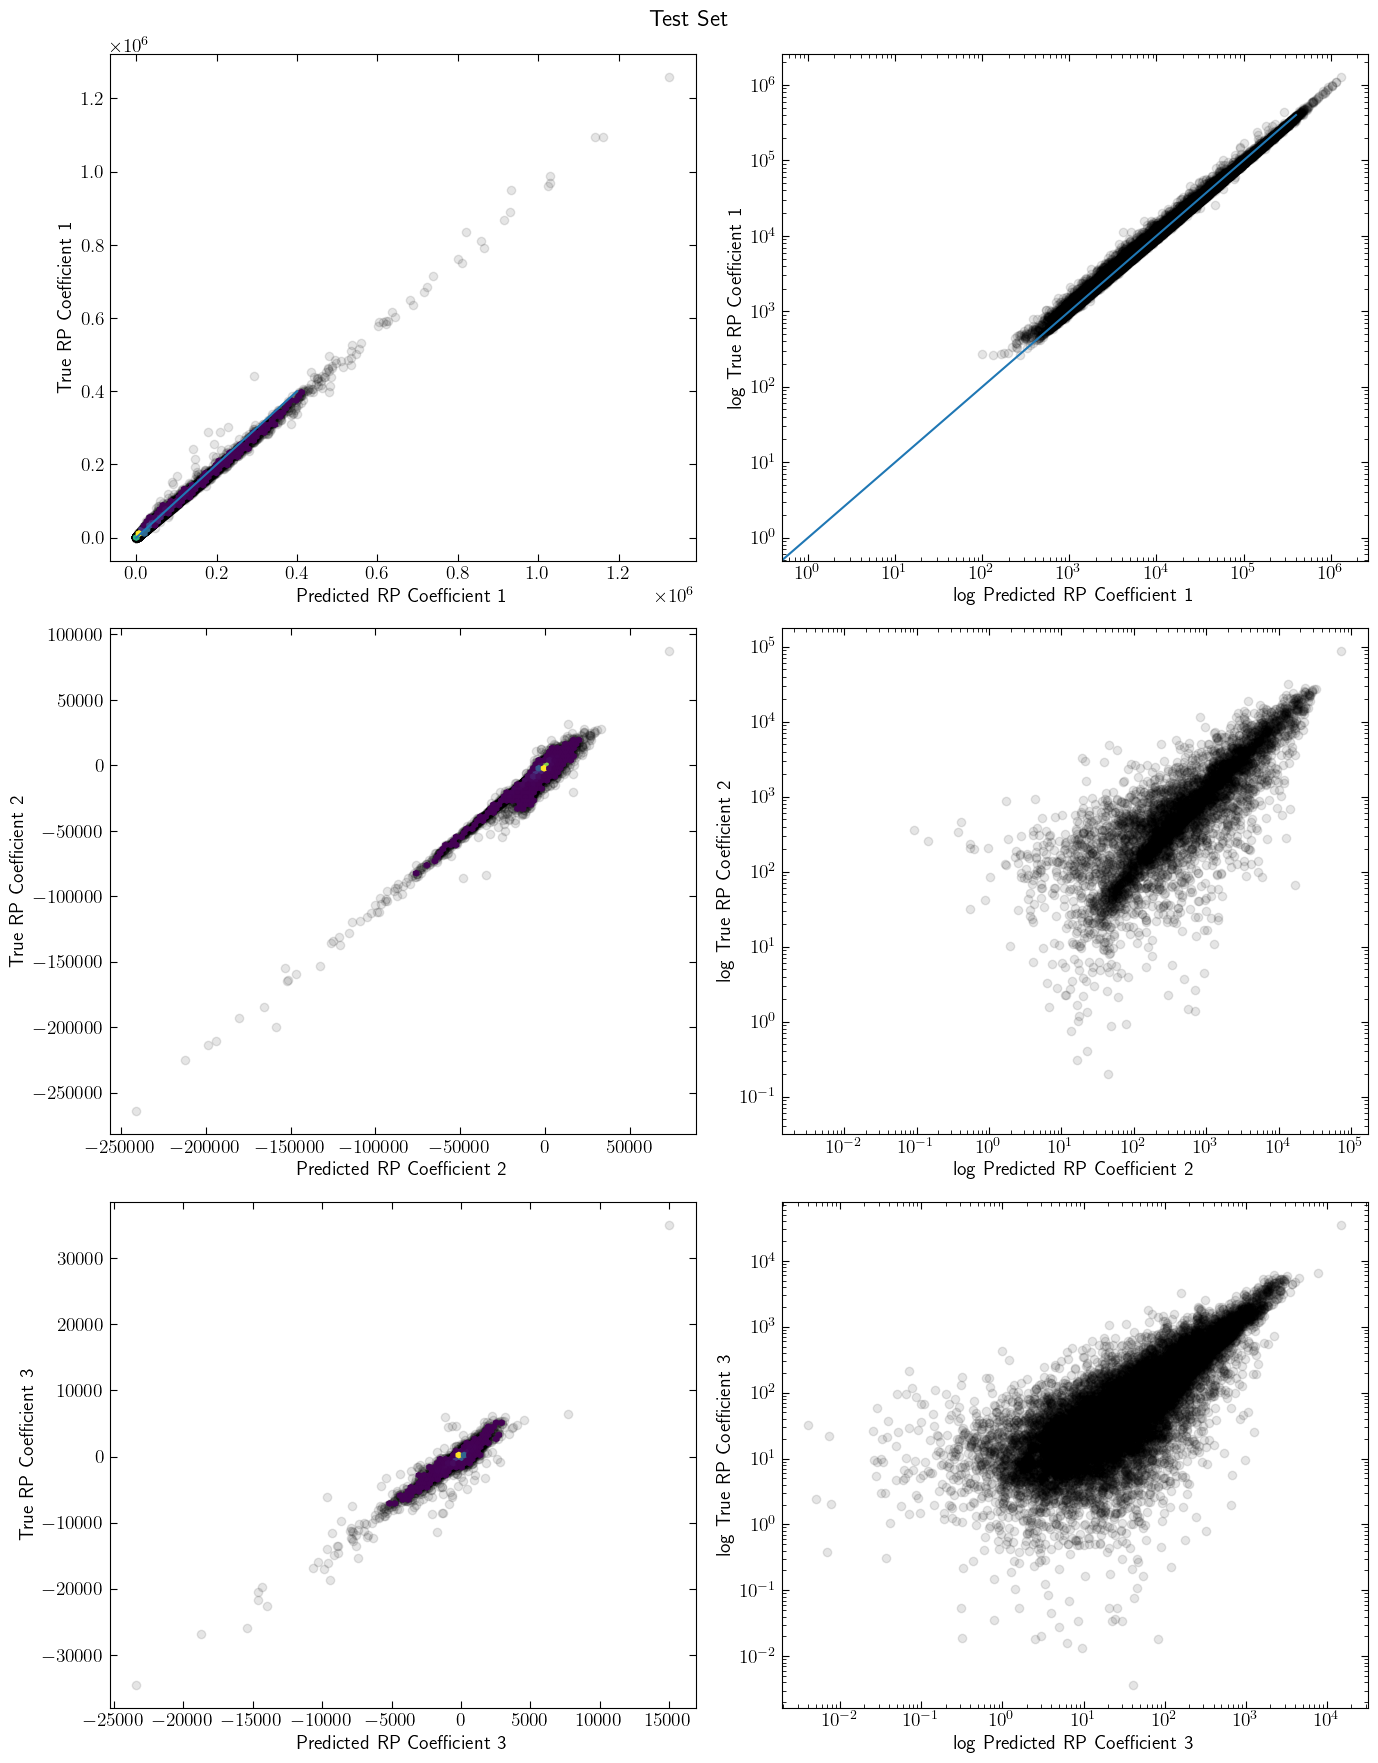

In [45]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Test Set')
axs[0,0].scatter(test_rp_preds[:,0],test_rp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(test_rp_preds[:,0],test_rp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True RP Coefficient 1')
axs[0,0].set_xlabel('Predicted RP Coefficient 1');
axs[0,1].scatter(test_rp_preds[:,0],test_rp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True RP Coefficient 1')
axs[0,1].set_xlabel('log Predicted RP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(test_rp_preds[:,1],test_rp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(test_rp_preds[:,1],test_rp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True RP Coefficient 2')
axs[1,0].set_xlabel('Predicted RP Coefficient 2');
axs[1,1].scatter(test_rp_preds[:,1],test_rp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True RP Coefficient 2')
axs[1,1].set_xlabel('log Predicted RP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(test_rp_preds[:,2],test_rp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(test_rp_preds[:,2],test_rp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True RP Coefficient 3')
axs[2,0].set_xlabel('Predicted RP Coefficient 3');
axs[2,1].scatter(test_rp_preds[:,2],test_rp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True RP Coefficient 3')
axs[2,1].set_xlabel('log Predicted RP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()

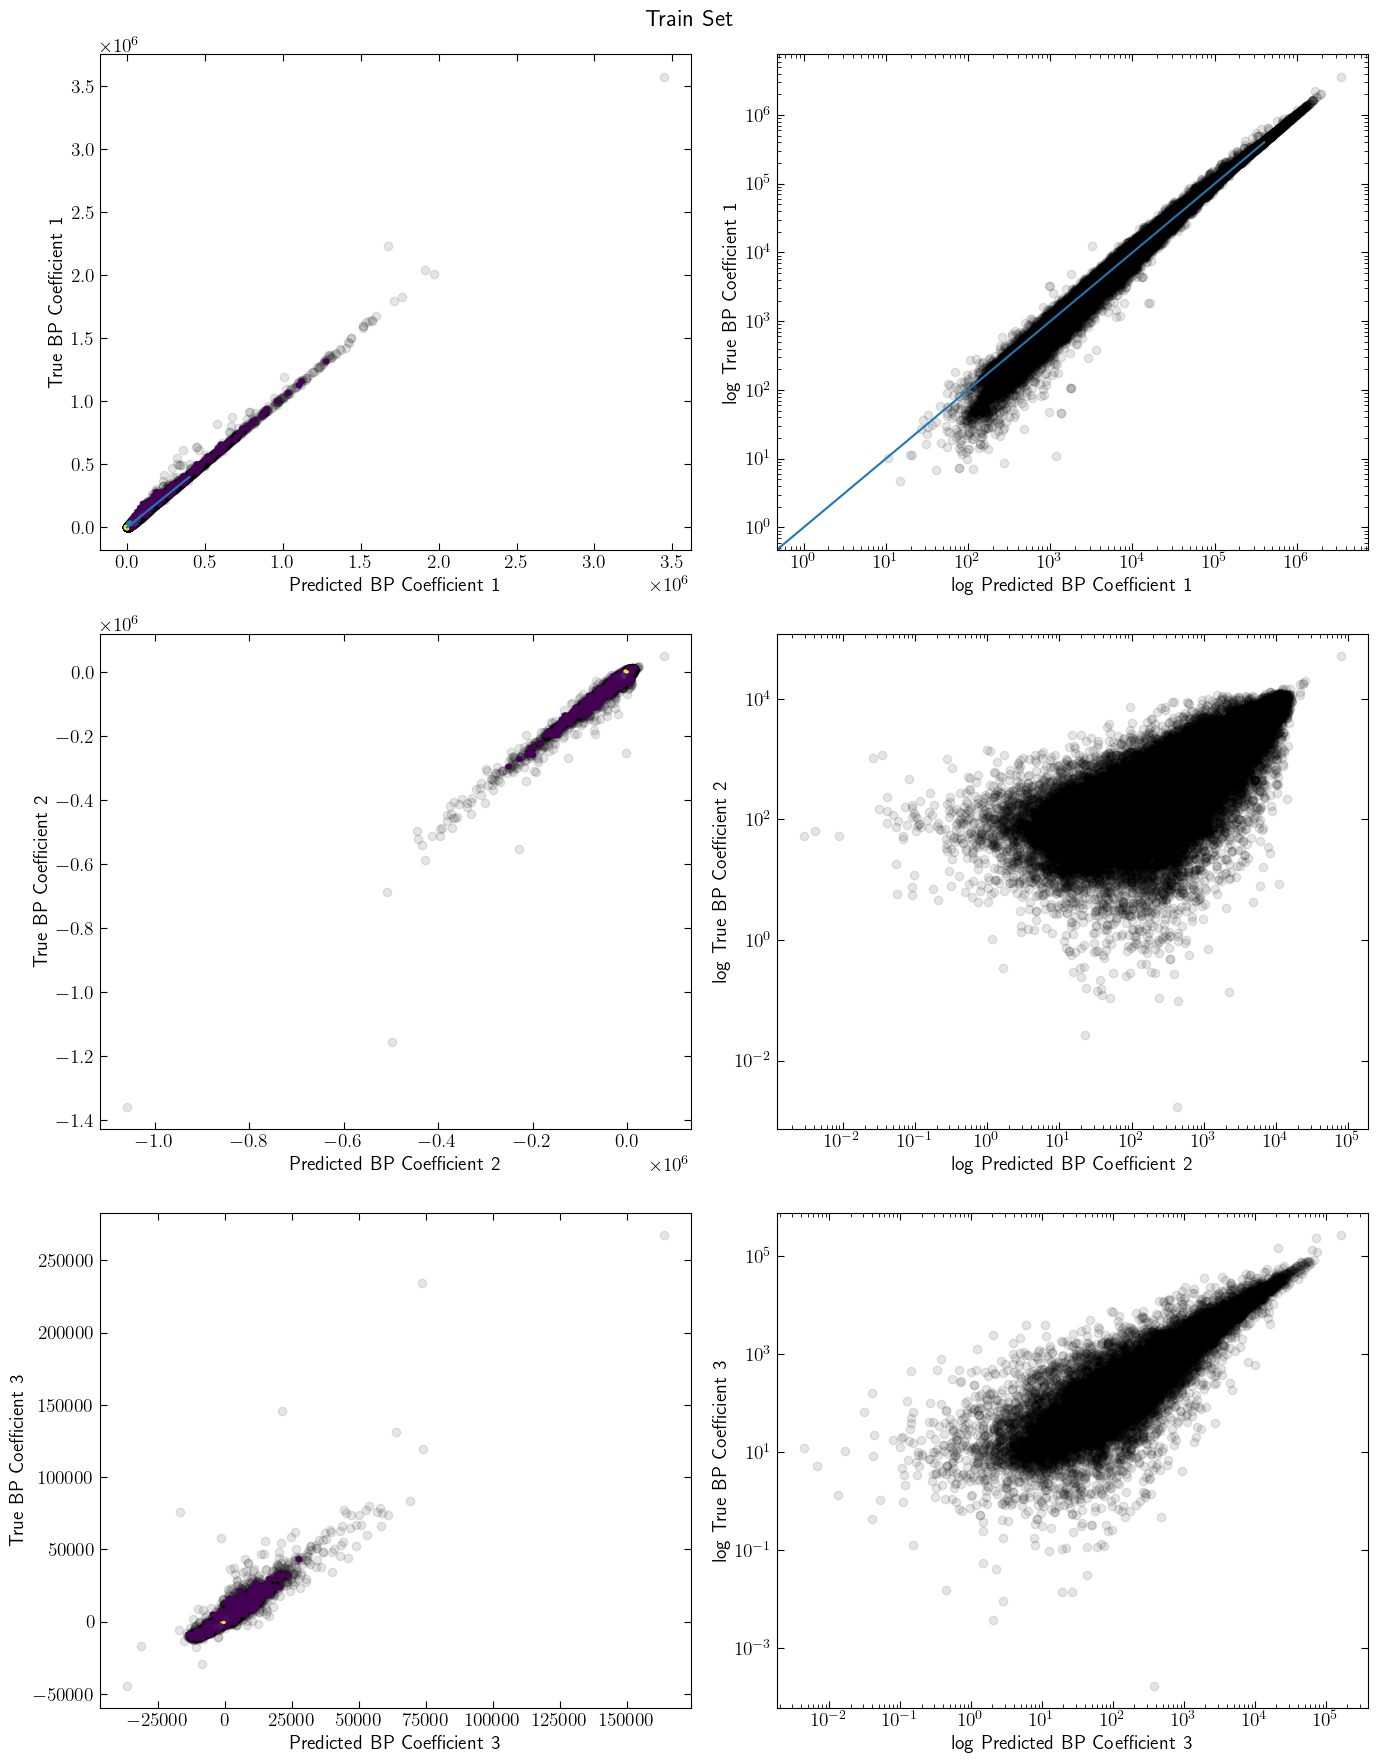

In [46]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Train Set')
axs[0,0].scatter(train_bp_preds[:,0],train_bp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(train_bp_preds[:,0],train_bp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True BP Coefficient 1')
axs[0,0].set_xlabel('Predicted BP Coefficient 1');
axs[0,1].scatter(train_bp_preds[:,0],train_bp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True BP Coefficient 1')
axs[0,1].set_xlabel('log Predicted BP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(train_bp_preds[:,1],train_bp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(train_bp_preds[:,1],train_bp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True BP Coefficient 2')
axs[1,0].set_xlabel('Predicted BP Coefficient 2');
axs[1,1].scatter(train_bp_preds[:,1],train_bp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True BP Coefficient 2')
axs[1,1].set_xlabel('log Predicted BP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(train_bp_preds[:,2],train_bp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(train_bp_preds[:,2],train_bp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True BP Coefficient 3')
axs[2,0].set_xlabel('Predicted BP Coefficient 3');
axs[2,1].scatter(train_bp_preds[:,2],train_bp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True BP Coefficient 3')
axs[2,1].set_xlabel('log Predicted BP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()

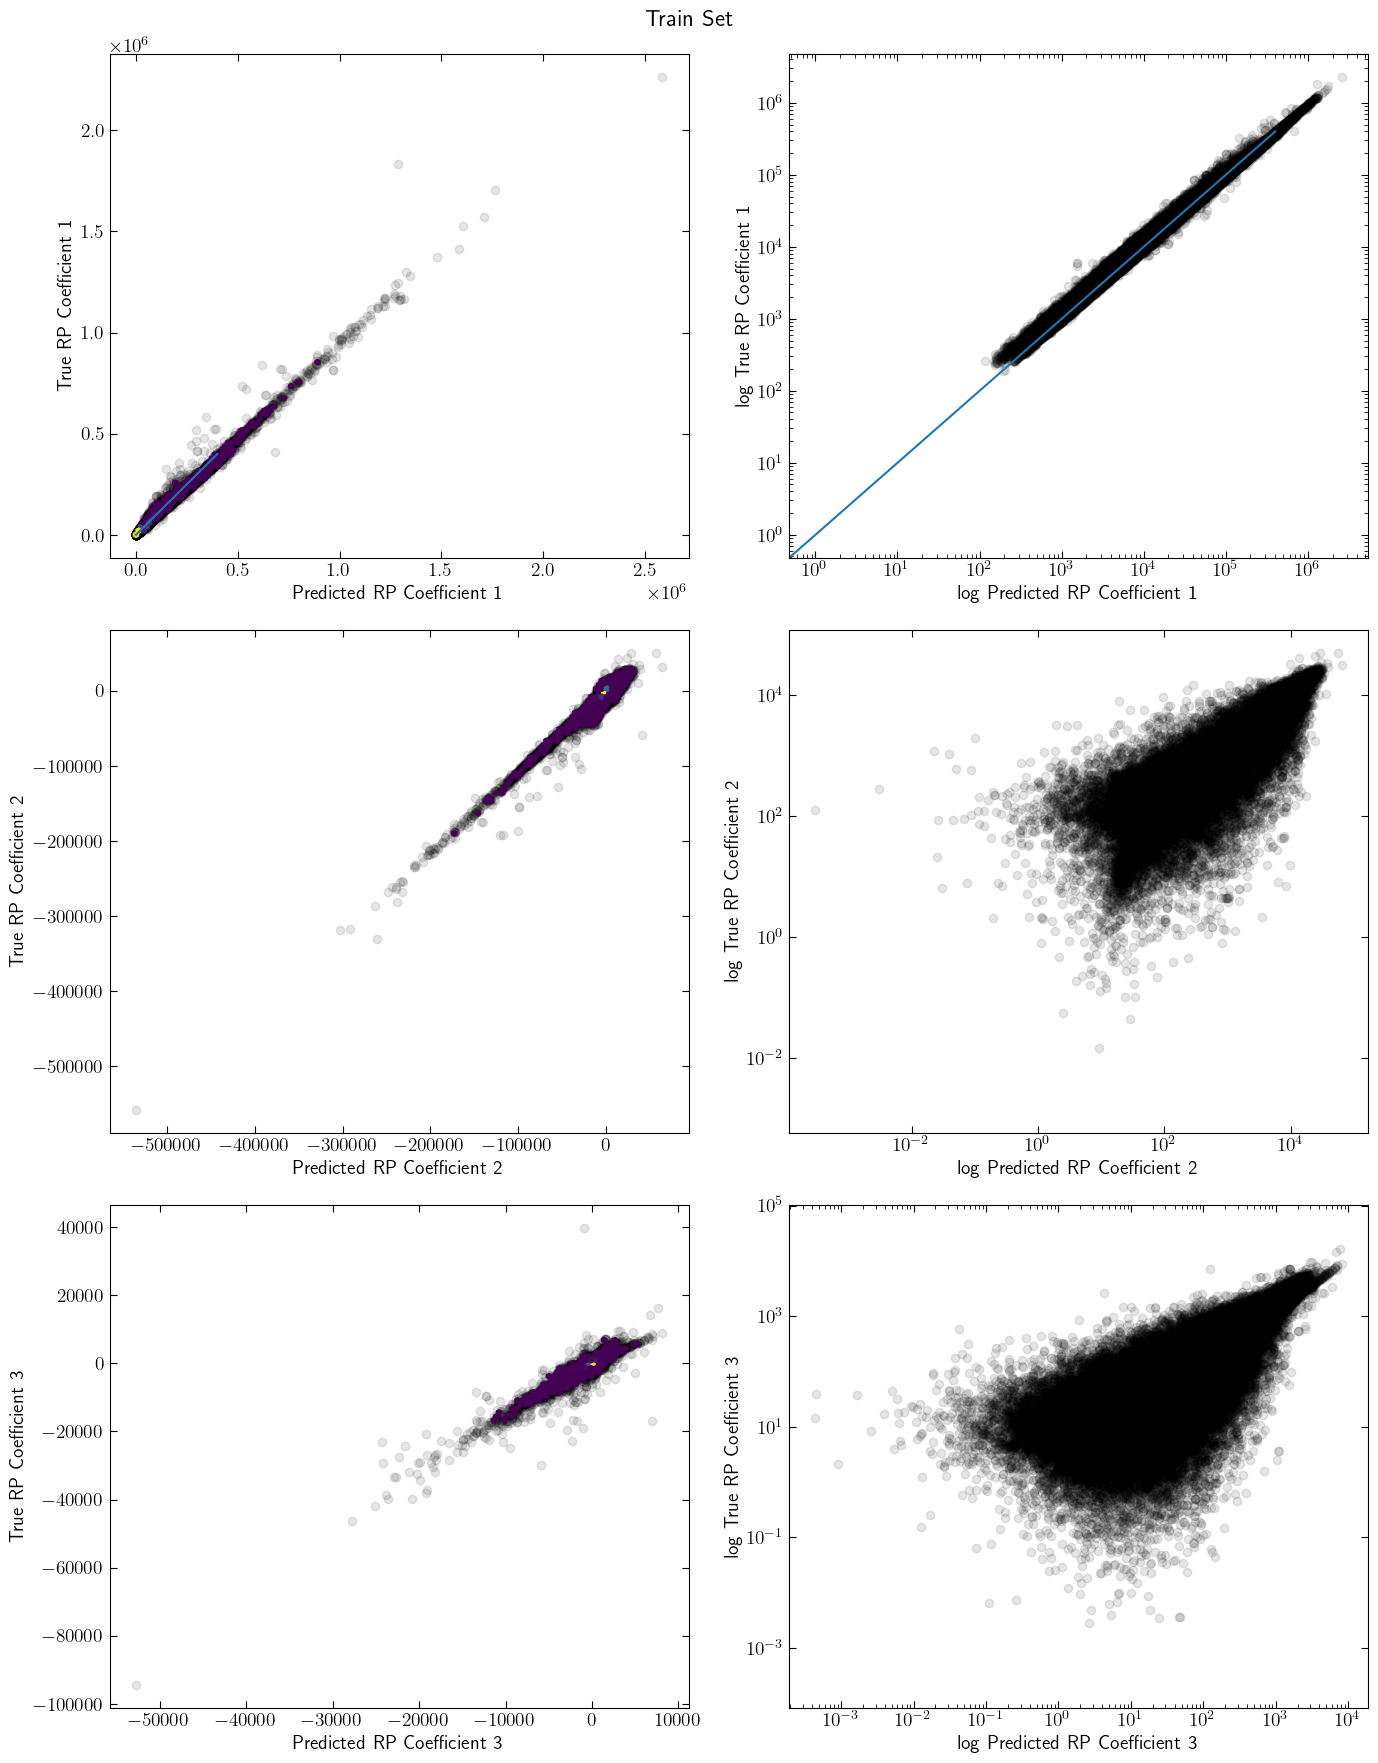

In [47]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Train Set')
axs[0,0].scatter(train_rp_preds[:,0],train_rp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True RP Coefficient 1')
axs[0,0].set_xlabel('Predicted RP Coefficient 1');
axs[0,1].scatter(train_rp_preds[:,0],train_rp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True RP Coefficient 1')
axs[0,1].set_xlabel('log Predicted RP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(train_rp_preds[:,1],train_rp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(train_rp_preds[:,1],train_rp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True RP Coefficient 2')
axs[1,0].set_xlabel('Predicted RP Coefficient 2');
axs[1,1].scatter(train_rp_preds[:,1],train_rp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True RP Coefficient 2')
axs[1,1].set_xlabel('log Predicted RP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(train_rp_preds[:,2],train_rp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(train_rp_preds[:,2],train_rp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True RP Coefficient 3')
axs[2,0].set_xlabel('Predicted RP Coefficient 3');
axs[2,1].scatter(train_rp_preds[:,2],train_rp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True RP Coefficient 3')
axs[2,1].set_xlabel('log Predicted RP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()